In [1]:
import pymc3 as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from theano import tensor as tt
import arviz as az

In [2]:
%config InlineBackend.figure_format = 'retina'
az.style.use('arviz-darkgrid')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#### Code 13.1

In [3]:
a = 3.5        # average morning wait time
b = -1.        # average difference afternoon wait time
sigma_a = 1.   # std dev in intercepts
sigma_b = 0.5  # std dev in slopes
rho = -0.7     # correlation between intercepts and slopes

#### Code 13.2

In [4]:
Mu = [a, b]  

#### Code 13.3

In [5]:
cov_ab = sigma_a * sigma_b * rho
Sigma = np.array([[sigma_a**2, cov_ab], [cov_ab, sigma_b**2]])
Sigma

array([[ 1.  , -0.35],
       [-0.35,  0.25]])

#### Code 13.4

The code 13.4 and the related comment in the book is particular to R and not relevant for Python.

#### Code 13.5

In [6]:
sigmas = [sigma_a, sigma_b]
Rho = np.matrix([[1, rho], [rho, 1]])

Sigma = np.diag(sigmas) * Rho * np.diag(sigmas)
Sigma

matrix([[ 1.  , -0.35],
        [-0.35,  0.25]])

#### Code 13.6

In [7]:
N_cafes = 20

#### Code 13.7

In [8]:
np.random.seed(42)
vary_effects = np.random.multivariate_normal(mean=Mu, cov=Sigma, size=N_cafes)

#### Code 13.8

In [9]:
a_cafe = vary_effects[:, 0]
b_cafe = vary_effects[:, 1]

#### Code 13.9

In [10]:
from matplotlib.patches import Ellipse
from scipy.stats import chi2
def Gauss2d(mu, cov, ci, ax=None):
    """Copied from statsmodel"""
    if ax is None:
        _, ax = plt.subplots(figsize=(6, 6))

    v_, w = np.linalg.eigh(cov)
    u = w[0] / np.linalg.norm(w[0])
    angle = np.arctan(u[1]/u[0])
    angle = 180 * angle / np.pi # convert to degrees

    for level in ci:
        v = 2 * np.sqrt(v_ * chi2.ppf(level, 2)) #get size corresponding to level
        ell = Ellipse(mu[:2], v[0], v[1], 180 + angle, facecolor='None',
                      edgecolor='k',
                      alpha=(1-level)*.5,
                      lw=1.5)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)
    
    return ax

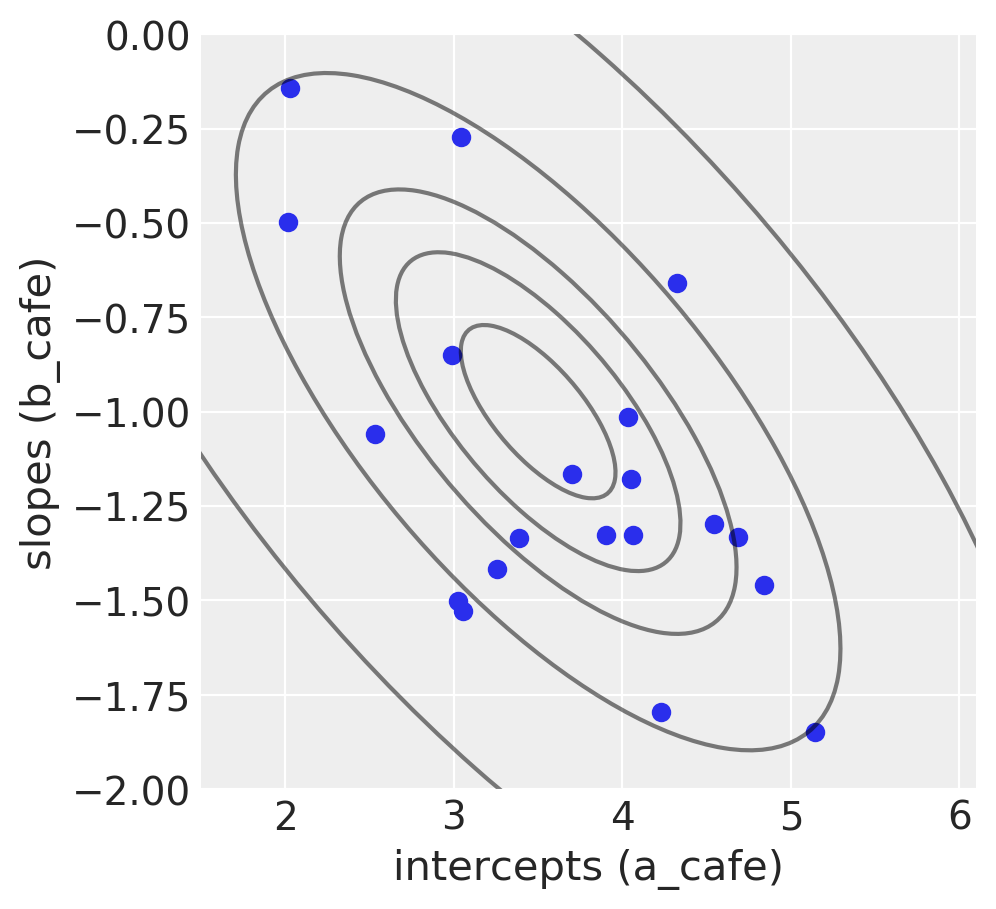

In [11]:
_, ax = plt.subplots(1, 1, figsize=(5, 5))
Gauss2d(Mu, np.asarray(Sigma), [0.1, 0.3, 0.5, 0.8, 0.99], ax=ax)
ax.scatter(a_cafe, b_cafe)
ax.set_xlim(1.5, 6.1)
ax.set_ylim(-2, 0)
ax.set_xlabel('intercepts (a_cafe)')
ax.set_ylabel('slopes (b_cafe)');

#### Code 13.10

In [12]:
N_visits = 10
afternoon = np.tile([0,1], N_visits * N_cafes//2)  # wrap with int() to suppress warnings
cafe_id = np.repeat(np.arange(0, N_cafes), N_visits)  # 1-20 (minus 1 for python indexing)

mu = a_cafe[cafe_id] + b_cafe[cafe_id]*afternoon
sigma = 0.5 # std dev within cafes
wait = np.random.normal(loc=mu, scale=sigma, size=N_visits*N_cafes)
d = pd.DataFrame(dict(cafe=cafe_id , afternoon=afternoon , wait=wait))

#### Code 13.11

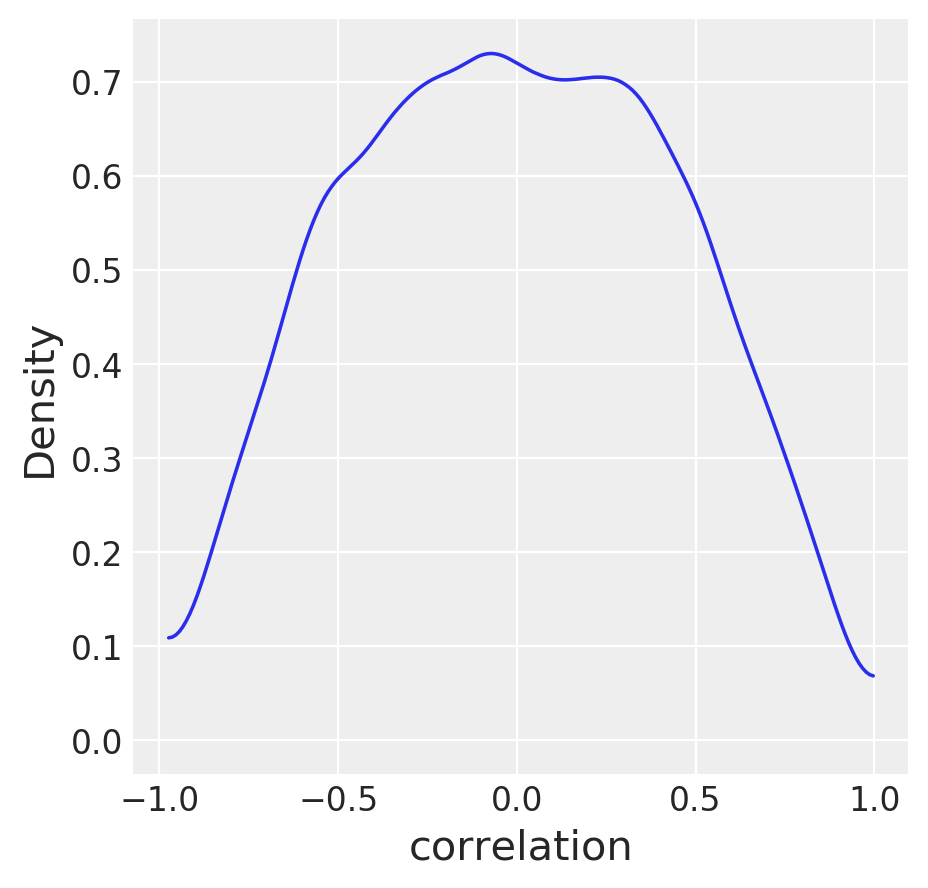

In [13]:
R = pm.LKJCorr.dist(n=2, eta=2).random(size=10000)
_, ax = plt.subplots(1, 1, figsize=(5, 5))
az.plot_kde(R);
ax.set_xlabel('correlation')
ax.set_ylabel('Density');

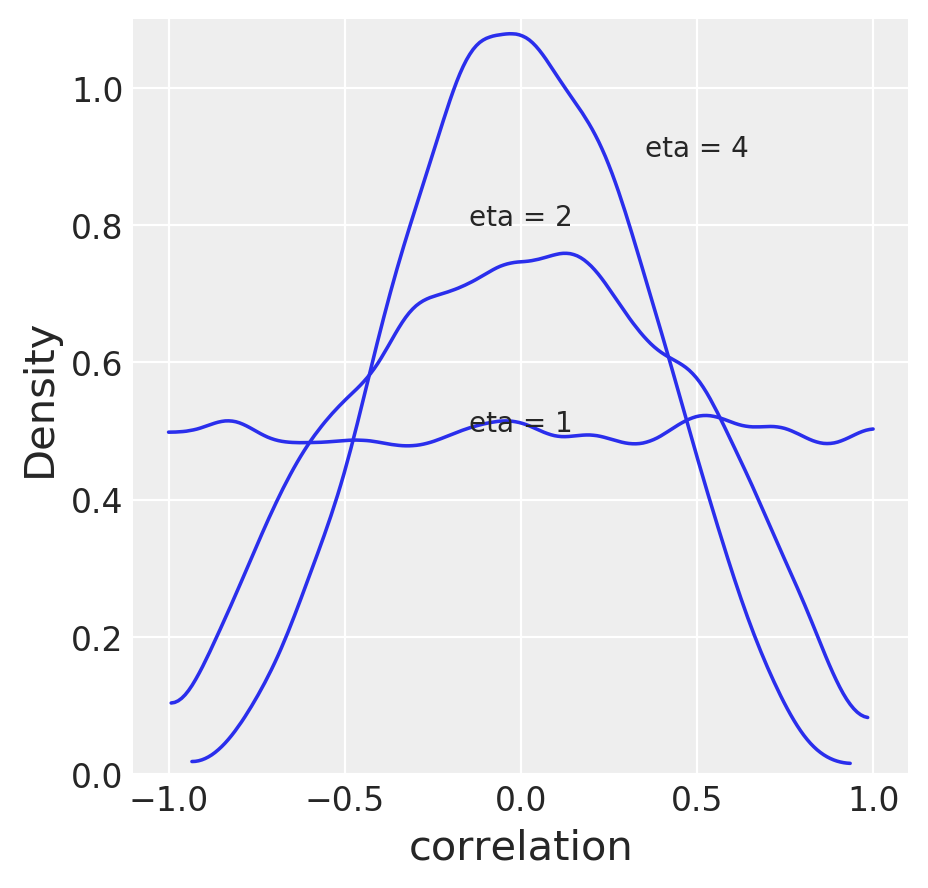

In [14]:
_, ax = plt.subplots(1, 1, figsize=(5, 5))
textloc = [[0, .5], [0, .8], [.5, .9]]
for eta, loc in zip([1, 2, 4], textloc):
    R = pm.LKJCorr.dist(n=2, eta=eta).random(size=10000)
    az.plot_kde(R);
    ax.text(loc[0], loc[1], 'eta = %s'%(eta), horizontalalignment='center')

ax.set_ylim(0, 1.1)
ax.set_xlabel('correlation')
ax.set_ylabel('Density');

#### Code 13.12

In [15]:
cafe_idx = d['cafe'].values
with pm.Model() as m_13_1:
    sd_dist = pm.HalfCauchy.dist(beta=2) # This is the same as sigma_cafe ~ dcauchy(0,2)
    packed_chol = pm.LKJCholeskyCov('chol_cov', eta=2, n=2, sd_dist=sd_dist)
    
    # compute the covariance matrix
    chol = pm.expand_packed_triangular(2, packed_chol, lower=True)
    cov = pm.math.dot(chol, chol.T)
    
    # Extract the standard deviations and rho
    sigma_ab = pm.Deterministic('sigma_cafe', tt.sqrt(tt.diag(cov)))
    corr = tt.diag(sigma_ab**-1).dot(cov.dot(tt.diag(sigma_ab**-1)))
    r = pm.Deterministic('Rho', corr[np.triu_indices(2, k=1)])
    
    ab = pm.Normal('ab', mu=0, sd=10, shape=2)  # prior for average intercept and slope
    ab_cafe = pm.MvNormal('ab_cafe', mu=ab, chol=chol, shape=(N_cafes, 2)) # Population of varying effects
    # Shape needs to be (N_cafes, 2) because we're getting back both a and b for each cafe
    
    mu = ab_cafe[:, 0][cafe_idx] + ab_cafe[:, 1][cafe_idx] * d['afternoon'].values  # linear model
    sd = pm.HalfCauchy('sigma', beta=2)      # prior stddev within cafes
    wait = pm.Normal('wait', mu=mu, sd=sd, observed=d['wait'])  # likelihood
    trace_13_1 = pm.sample(5000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, ab_cafe, ab, chol_cov]
Sampling 4 chains: 100%|██████████| 28000/28000 [00:49<00:00, 566.70draws/s]
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


For complex models it is always good to do more checks:

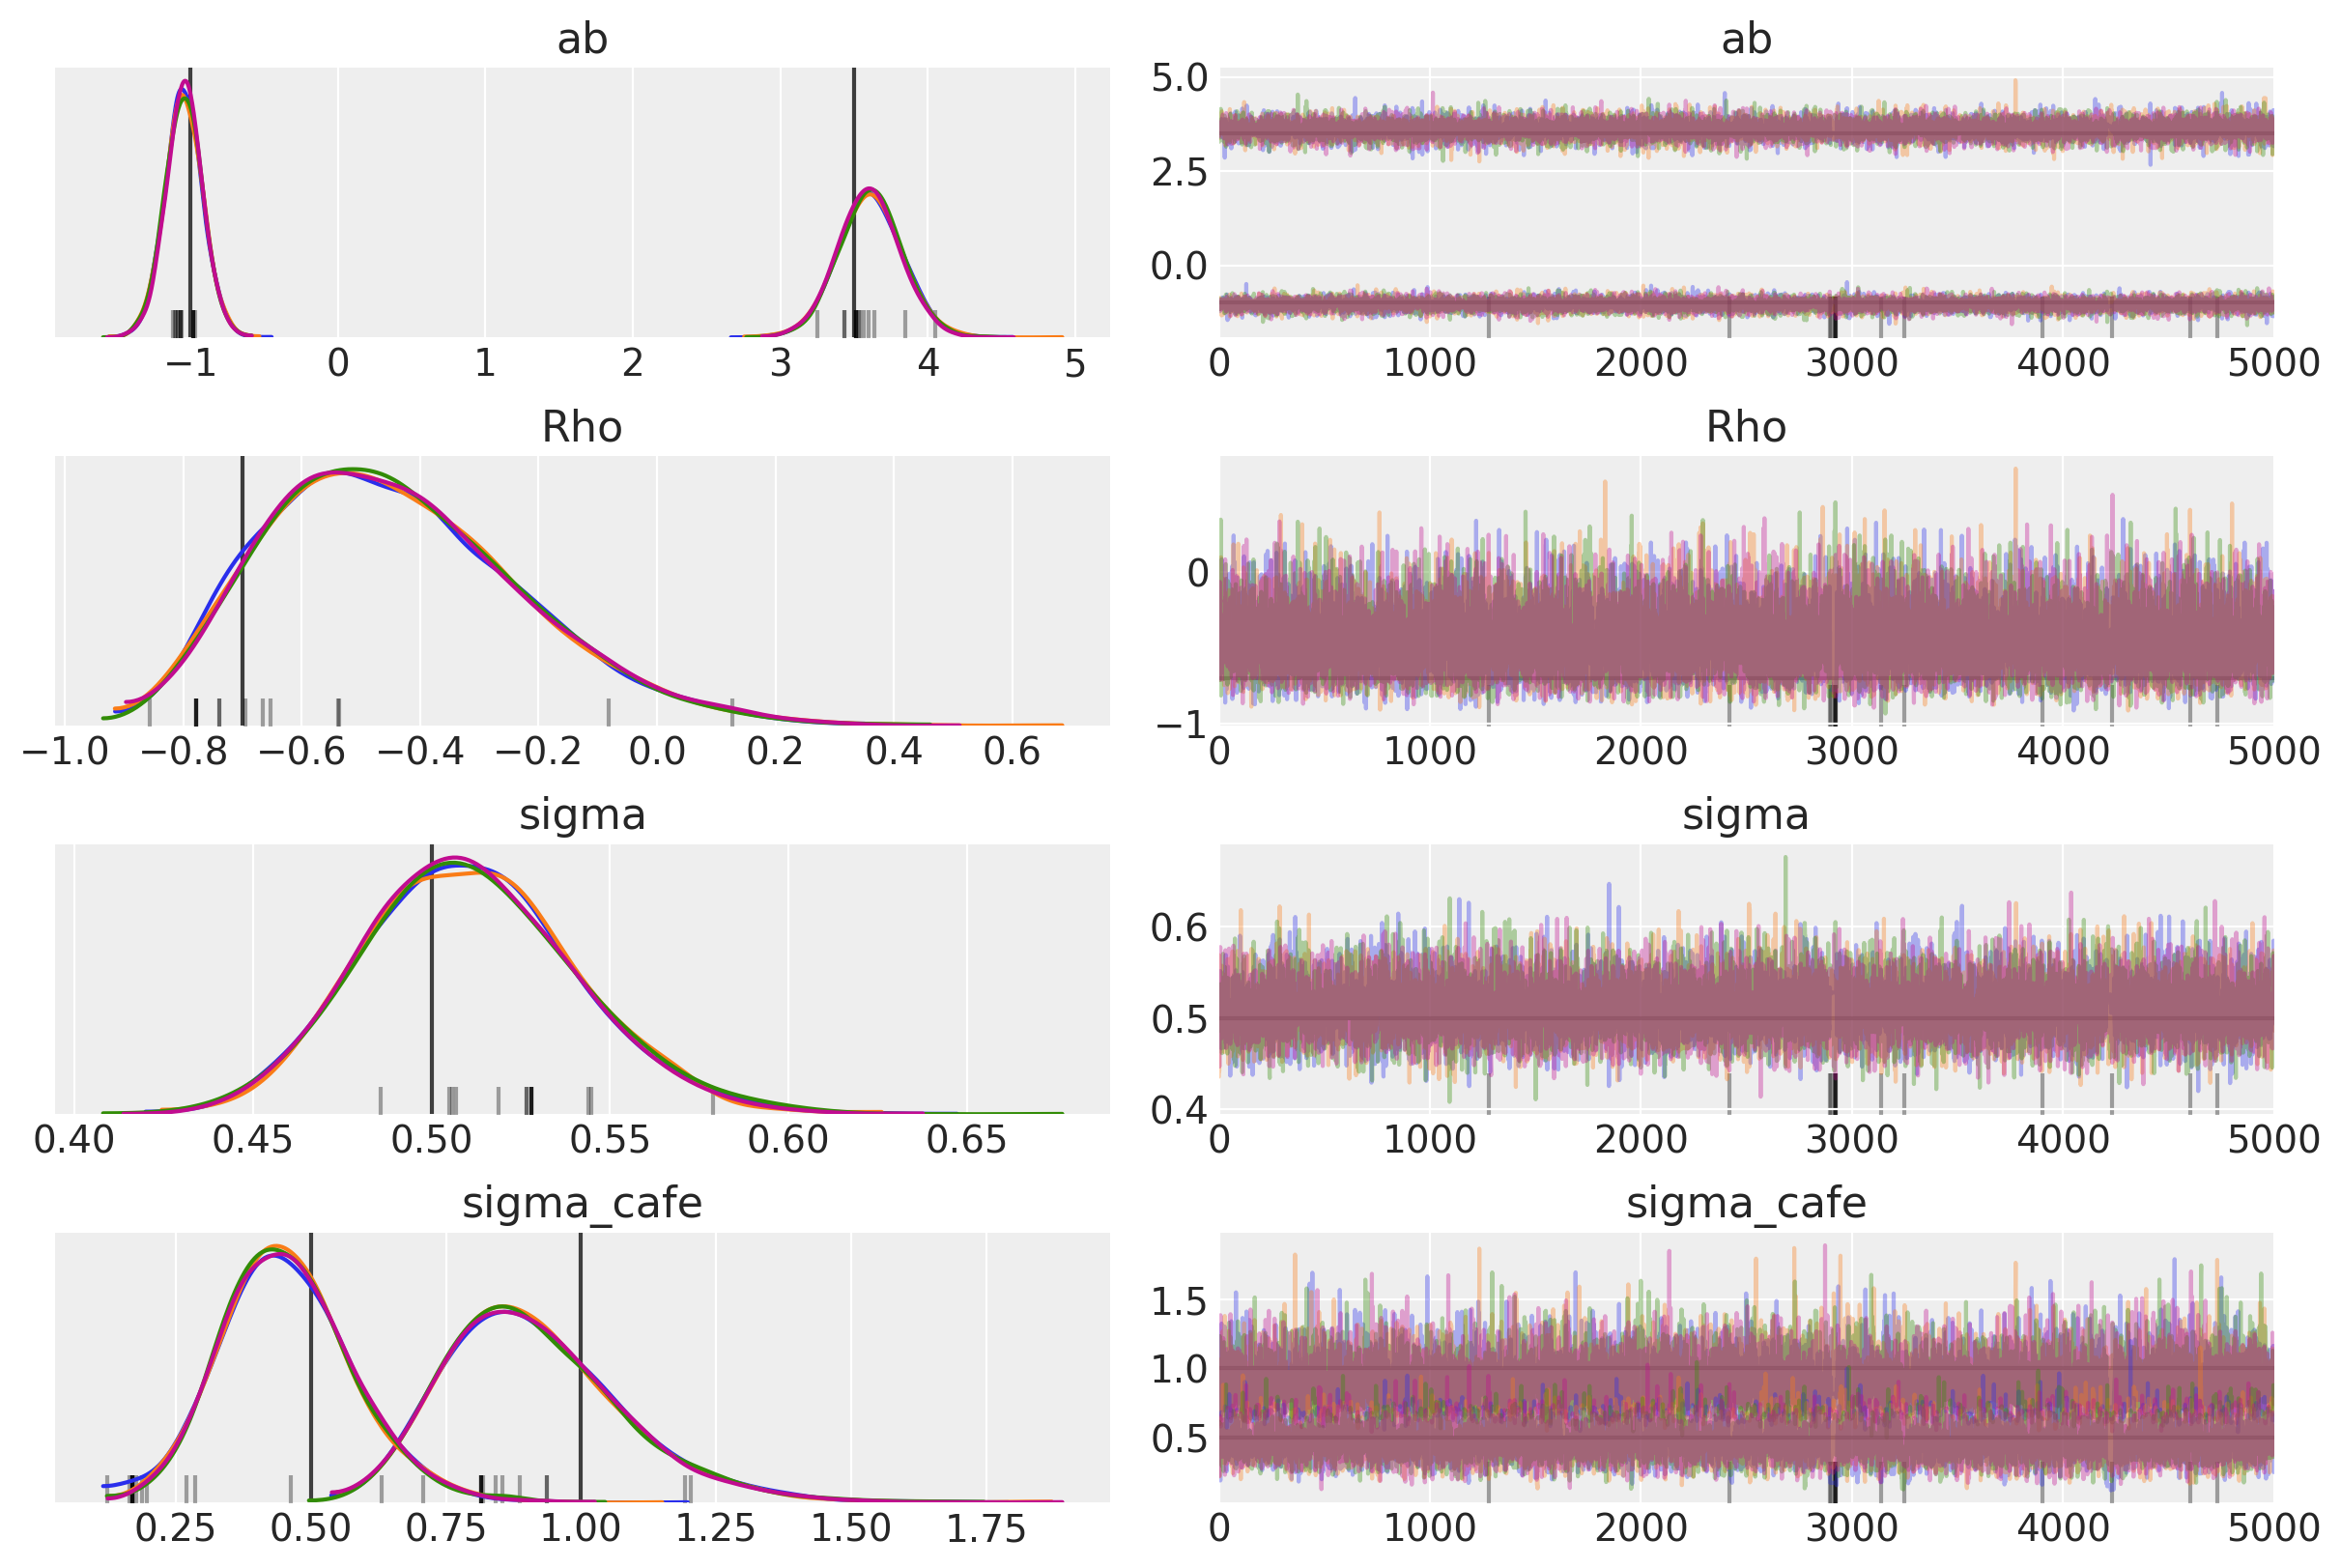

In [16]:
az.plot_trace(trace_13_1, var_names=['ab', 'Rho', 'sigma', 'sigma_cafe'], compact=True,
              lines=[("ab", {}, Mu),
                    ("Rho", {}, rho),
                    ("sigma", {}, sigma),
                    ("sigma_cafe", {}, sigmas)]);

### Alternate formulation using `pm.LKJCorr` instead of `pm.LKJCholeskyCov`

In [17]:
def up_tri_to_mat_indices(ndim, k=1):
    n_elem = ndim * (ndim - 1) / 2
    tri_index = np.zeros([ndim, ndim], dtype=int)
    tri_index[np.triu_indices(ndim, k=k)] = np.arange(n_elem)
    tri_index[np.triu_indices(ndim, k=k)[::-1]] = np.arange(n_elem)
    return tri_index

In [18]:
dim = 2
with pm.Model() as m_13_1_alt:
    # prior on upper tringular correlation matrix
    corr_triu = pm.LKJCorr('corr_triu', n=dim, eta=2)
    # convert upper tringular to full correlation matrix
    corr = pm.Deterministic('corr', tt.fill_diagonal(corr_triu[up_tri_to_mat_indices(dim)], 1.))
    # track correlation scalar
    r = pm.Deterministic('Rho', corr[np.triu_indices(2, k=1)])
    # this extras are needed to convert the correlation matrix to a covariance matrix
    # since `pm.MvNormal` does not accept correlation matrices
    sigma_ab = pm.HalfCauchy('sigma_cafe', beta=2, shape=dim)
    sigma_diag = pm.Deterministic('sigma_mat', tt.nlinalg.diag(sigma_ab))
    cov = pm.Deterministic('cov', tt.nlinalg.matrix_dot(sigma_diag, corr, sigma_diag))
    # prior for average intercept and slope
    ab = pm.Normal('ab', mu=0, sd=10, shape=2)  
    # Population of varying effects
    # Shape needs to be (N_cafes, 2) because we're getting back both a and b for each cafe
    ab_cafe = pm.MvNormal('ab_cafe', mu=ab, cov=cov, shape=(N_cafes, 2))     
    # linear model
    mu = ab_cafe[:, 0][cafe_idx] + ab_cafe[:, 1][cafe_idx] * d['afternoon'].values 
    # prior stddev within cafes
    sd = pm.HalfCauchy('sigma', beta=2)     
    # likelihood
    wait = pm.Normal('wait', mu=mu, sd=sd, observed=d['wait'])  
    # sample posterior
    trace_13_1_alt = pm.sample(5000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, ab_cafe, ab, sigma_cafe, corr_triu]
Sampling 4 chains: 100%|██████████| 28000/28000 [01:19<00:00, 351.27draws/s]
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


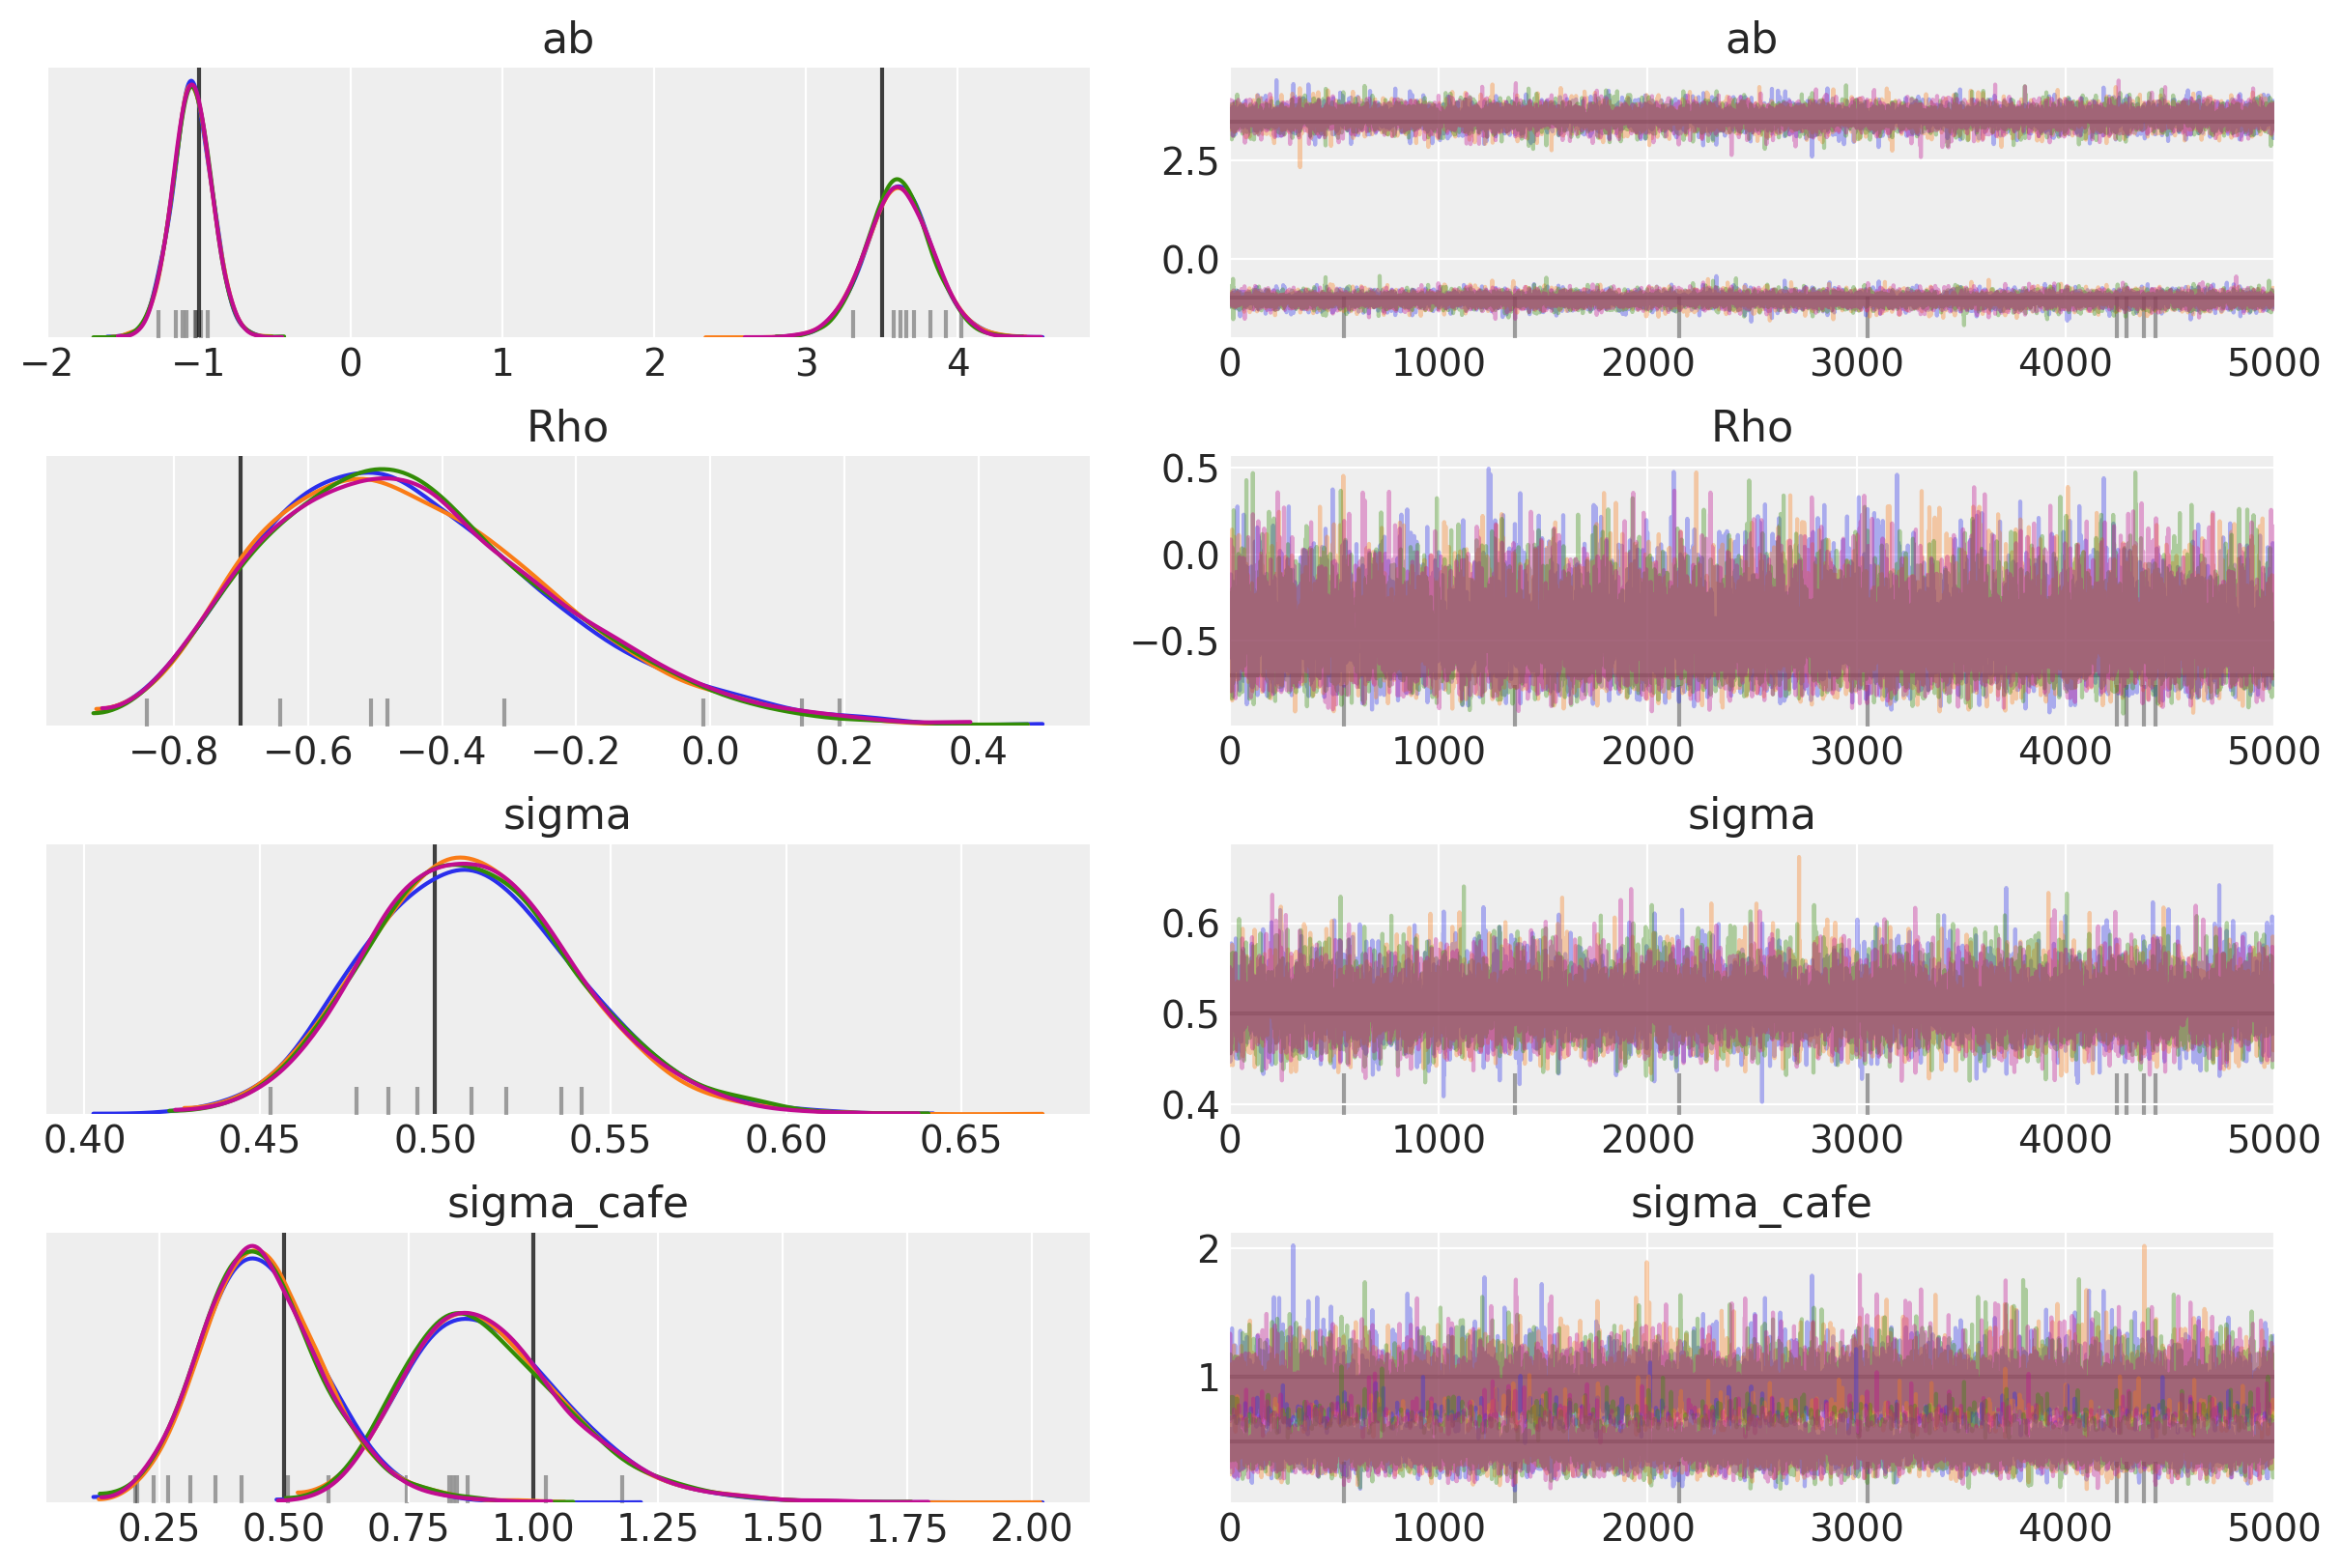

In [19]:
az.plot_trace(trace_13_1_alt, var_names=['ab', 'Rho', 'sigma', 'sigma_cafe'], compact=True,
              lines=[("ab", {}, Mu),
                    ("Rho", {}, rho),
                    ("sigma", {}, sigma),
                    ("sigma_cafe", {}, sigmas)]);

#### Code 13.13

In [20]:
post = pm.trace_to_dataframe(trace_13_1)

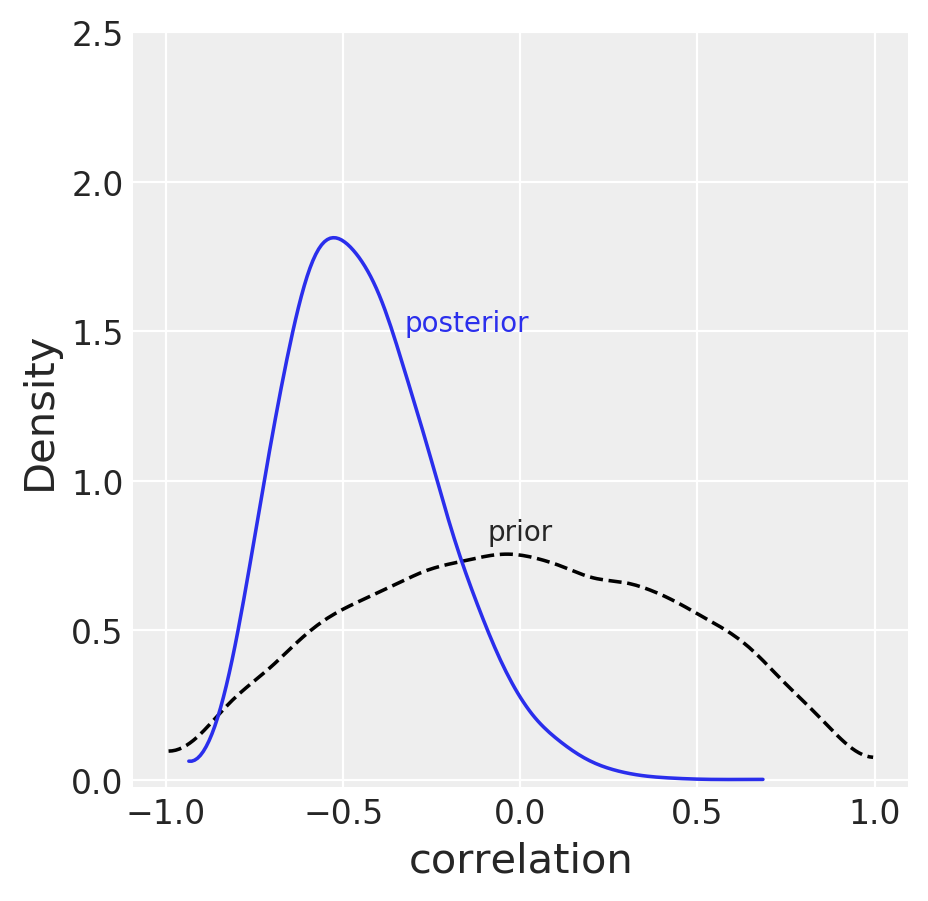

In [21]:
_, ax = plt.subplots(1, 1, figsize=(5, 5))
R = pm.LKJCorr.dist(n=2, eta=2).random(size=10000)
az.plot_kde(R, plot_kwargs={'color':'k', 'linestyle':'--'})
ax.text(0, .8, 'prior', horizontalalignment='center')
az.plot_kde(trace_13_1['Rho'], plot_kwargs={'color':'C0'})
ax.text(-.15, 1.5, 'posterior', color='C0', horizontalalignment='center')
ax.set_ylim(-.025, 2.5)
ax.set_xlabel('correlation')
ax.set_ylabel('Density');

#### Code 13.14

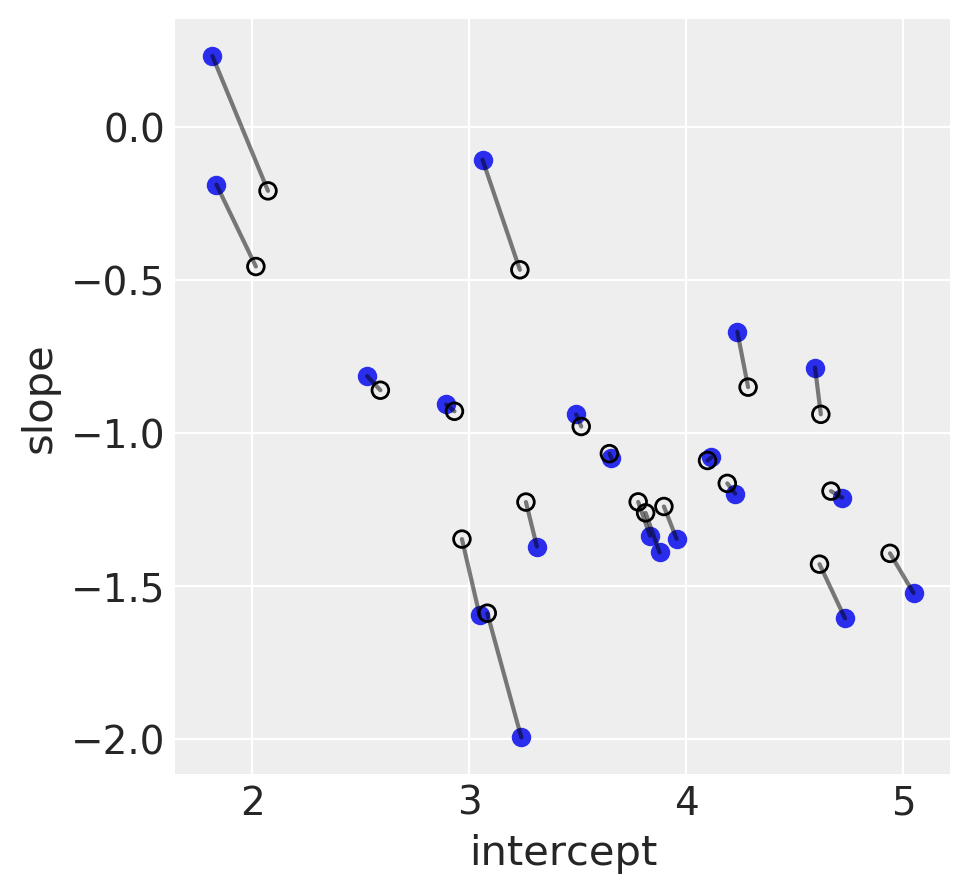

In [22]:
# compute unpooled estimates directly from data
a1b1 = (d.groupby(['afternoon', 'cafe'])
        .agg('mean')
        .unstack(level=0)
        .values)
a1 = a1b1[:, 0]
b1 = a1b1[:, 1] - a1

# extract posterior means of partially pooled estimates
a2b2 = trace_13_1['ab_cafe'].mean(axis=0)
a2 = a2b2[:, 0]
b2 = a2b2[:, 1]

# plot both and connect with lines
_, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.scatter(a1, b1)
ax.scatter(a2, b2, 
           facecolors='none', edgecolors='k', lw=1)

ax.plot([a1, a2], [b1, b2], 'k-', alpha=.5)
ax.set_xlabel('intercept')
ax.set_ylabel('slope');

#### Code 13.15

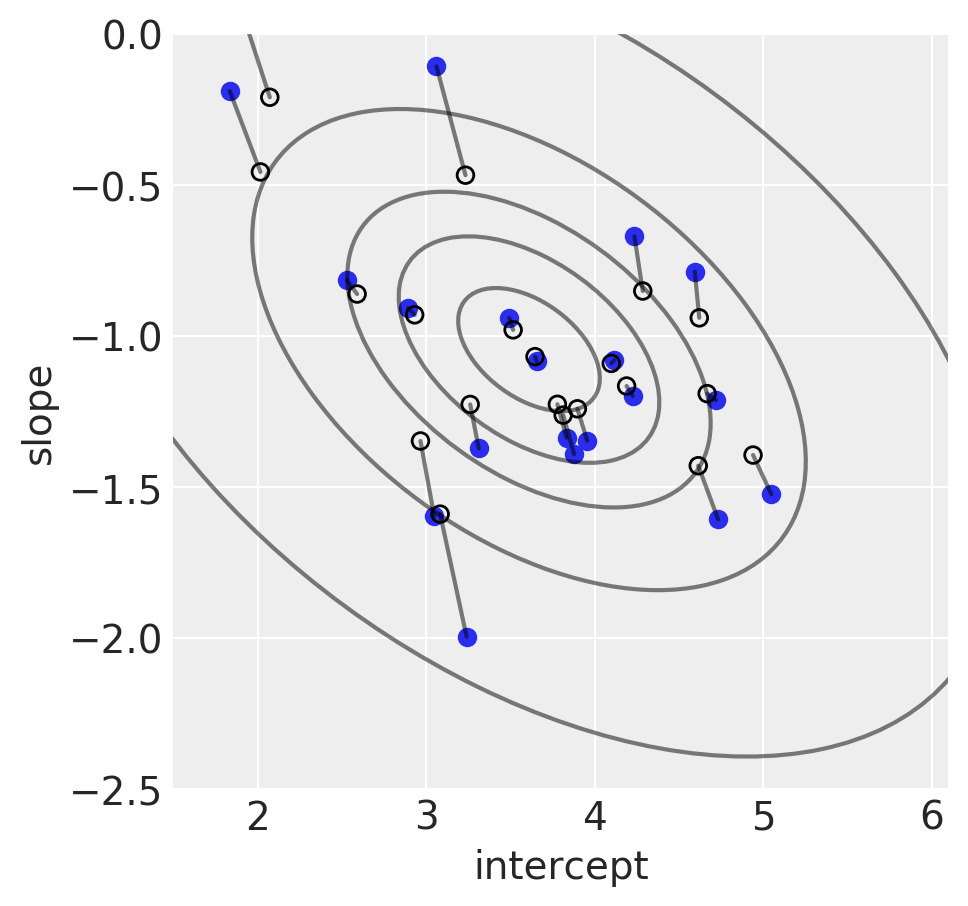

In [23]:
# compute posterior mean bivariate Gaussian
Mu_est = trace_13_1['ab'].mean(axis=0)
L_chol = pm.expand_packed_triangular(2, trace_13_1['chol_cov'].mean(0),lower=True).eval()
Sigma_est = np.dot(L_chol, L_chol.T)
# draw contours
_, ax = plt.subplots(1, 1, figsize=(5, 5))
Gauss2d(Mu_est, np.asarray(Sigma_est), [0.1, 0.3, 0.5, 0.8, 0.99], ax=ax)
ax.scatter(a1, b1)
ax.scatter(a2, b2, 
           facecolors='none', edgecolors='k', lw=1)
ax.plot([a1, a2], [b1, b2], 'k-', alpha=.5)
ax.set_xlabel('intercept', fontsize=14)
ax.set_ylabel('slope', fontsize=14)
ax.set_xlim(1.5, 6.1)
ax.set_ylim(-2.5, 0);

#### Code 13.16

In [24]:
# convert varying effects to waiting times
wait_morning_1 = a1
wait_afternoon_1 = a1 + b1
wait_morning_2 = a2
wait_afternoon_2 = a2 + b2

#### Code 13.17

In [25]:
d_ad = pd.read_csv('./Data/UCBadmit.csv', sep=';')
d_ad['male'] = (d_ad['applicant.gender'] == 'male').astype(int)
d_ad['dept_id'] = pd.Categorical(d_ad['dept']).codes

#### Code 13.18

In [26]:
Dept_id = d_ad['dept_id'].values
Ndept = len(d_ad['dept_id'].unique())
with pm.Model() as m_13_2:
    a = pm.Normal('a', 0, 10)
    bm = pm.Normal('bm', 0, 1)
    sigma_dept = pm.HalfCauchy('sigma_dept', 2)
    a_dept = pm.Normal('a_dept', a, sigma_dept, shape=Ndept)
    p = pm.math.invlogit(a_dept[Dept_id] + bm * d_ad['male'])
    admit = pm.Binomial('admit', p=p, n=d_ad.applications, observed=d_ad.admit)
    
    trace_13_2 = pm.sample(4500, tune=500)

az.summary(trace_13_2, credible_interval=.89, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a_dept, sigma_dept, bm, a]
Sampling 4 chains: 100%|██████████| 20000/20000 [00:07<00:00, 2845.37draws/s]


mean    sd  hpd_5.5%  hpd_94.5%  mcse_mean  mcse_sd  ess_mean  \
a          -0.59  0.63     -1.59       0.37       0.01      0.0  13760.52   
bm         -0.10  0.08     -0.23       0.03       0.00      0.0  11083.02   
a_dept[0]   0.68  0.10      0.52       0.83       0.00      0.0  13493.14   
a_dept[1]   0.63  0.11      0.44       0.81       0.00      0.0  13788.23   
a_dept[2]  -0.58  0.07     -0.70      -0.46       0.00      0.0  20917.97   
a_dept[3]  -0.62  0.09     -0.76      -0.48       0.00      0.0  18267.09   
a_dept[4]  -1.06  0.10     -1.21      -0.90       0.00      0.0  25388.98   
a_dept[5]  -2.61  0.16     -2.86      -2.36       0.00      0.0  24262.52   
sigma_dept  1.48  0.58      0.73       2.20       0.01      0.0  12624.89   

              ess_sd  ess_bulk  ess_tail  r_hat  
a           10619.80  15806.58   8608.52    1.0  
bm          11040.60  11082.91  13247.86    1.0  
a_dept[0]   13479.19  13496.24  14683.97    1.0  
a_dept[1]   13788.23  13790.80  13819.58    1.0  
a_dept[2]   20654.52  20911.50  13774.35    1.0  
a_dept[3]   18010.54  18314.47  14622.01    1.0  
a_dept[4]   25104.65  25423.87  13305.76    1.0  
a_dept[5]   23944.15  24373.40  13092.03    1.0  
sigma_dept  11177.55  16910.09  11417.07    1.0

#### Code 13.19

In [27]:
with pm.Model() as m_13_3:
    a = pm.Normal('a', 0, 10)
    bm = pm.Normal('bm', 0, 1)
    
    sd_dist = pm.HalfCauchy.dist(beta=2)
    packed_chol = pm.LKJCholeskyCov('chol_cov', eta=2, n=2, sd_dist=sd_dist)
    
    # compute the covariance matrix
    chol = pm.expand_packed_triangular(2, packed_chol, lower=True)
    cov = pm.math.dot(chol, chol.T)
    
    # Extract the standard deviations and rho
    sigma_ab = pm.Deterministic('sigma_dept', tt.sqrt(tt.diag(cov)))
    corr = tt.diag(sigma_ab**-1).dot(cov.dot(tt.diag(sigma_ab**-1)))
    r = pm.Deterministic('Rho', corr[np.triu_indices(2, k=1)])
    
    mu = pm.MvNormal('ab_dept', mu=tt.stack([a, bm]), chol=chol, shape=(Ndept, 2))
    
    a_dept = pm.Deterministic('a_dept', mu[:, 0])
    bm_dept = pm.Deterministic('bm_dept', mu[:, 1])
    
    p = pm.math.invlogit(mu[Dept_id, 0] + mu[Dept_id, 1] * d_ad['male'])
    admit = pm.Binomial('admit', p=p, n=d_ad.applications, observed=d_ad.admit)
    
    trace_13_3 = pm.sample(5000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ab_dept, chol_cov, bm, a]
Sampling 4 chains: 100%|██████████| 24000/24000 [01:03<00:00, 375.12draws/s]
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.


### Alternate formulation using `pm.LKJCorr` instead of `pm.LKJCholeskyCov`

In [28]:
dim = 2
with pm.Model() as m_13_3_alt:
    # prior on upper tringular correlation matrix
    corr_triu = pm.LKJCorr('corr_triu', n=dim, eta=2)
    # convert upper tringular to full correlation matrix
    corr = pm.Deterministic('corr', tt.fill_diagonal(corr_triu[up_tri_to_mat_indices(dim)], 1.))
    # track correlation scalar
    r = pm.Deterministic('Rho', corr[np.triu_indices(2, k=1)])
    #  convert the correlation matrix to a covariance matrix since `pm.MvNormal` 
    # does not accept correlation matrices
    sigma_ab = pm.HalfCauchy('sigma_dept', beta=2, shape=dim)
    sigma_diag = pm.Deterministic('sigma_mat', tt.nlinalg.diag(sigma_ab))
    cov = pm.Deterministic('cov', tt.nlinalg.matrix_dot(sigma_diag, corr, sigma_diag))  
    # priors on means of intercepts and slopes
    a = pm.Normal('a', 0, 10)
    bm = pm.Normal('bm', 0, 1)
    # Population of varying effects
    mu = pm.MvNormal('ab_dept', mu=tt.stack([a, bm]), cov=cov, shape=(Ndept, 2)) 
    # record posterior of intercepts and slopes
    a_dept = pm.Deterministic('a_dept', mu[:, 0])
    bm_dept = pm.Deterministic('bm_dept', mu[:, 1])
    # probability of admition
    p = pm.math.invlogit(mu[Dept_id, 0] + mu[Dept_id, 1] * d_ad['male'])
    # likelihood
    admit = pm.Binomial('admit', p=p, n=d_ad.applications, observed=d_ad.admit)
    # sample posterior
    trace_13_3_alt = pm.sample(5000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ab_dept, bm, a, sigma_dept, corr_triu]
Sampling 4 chains: 100%|██████████| 24000/24000 [01:37<00:00, 246.58draws/s]
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


#### Code 13.20

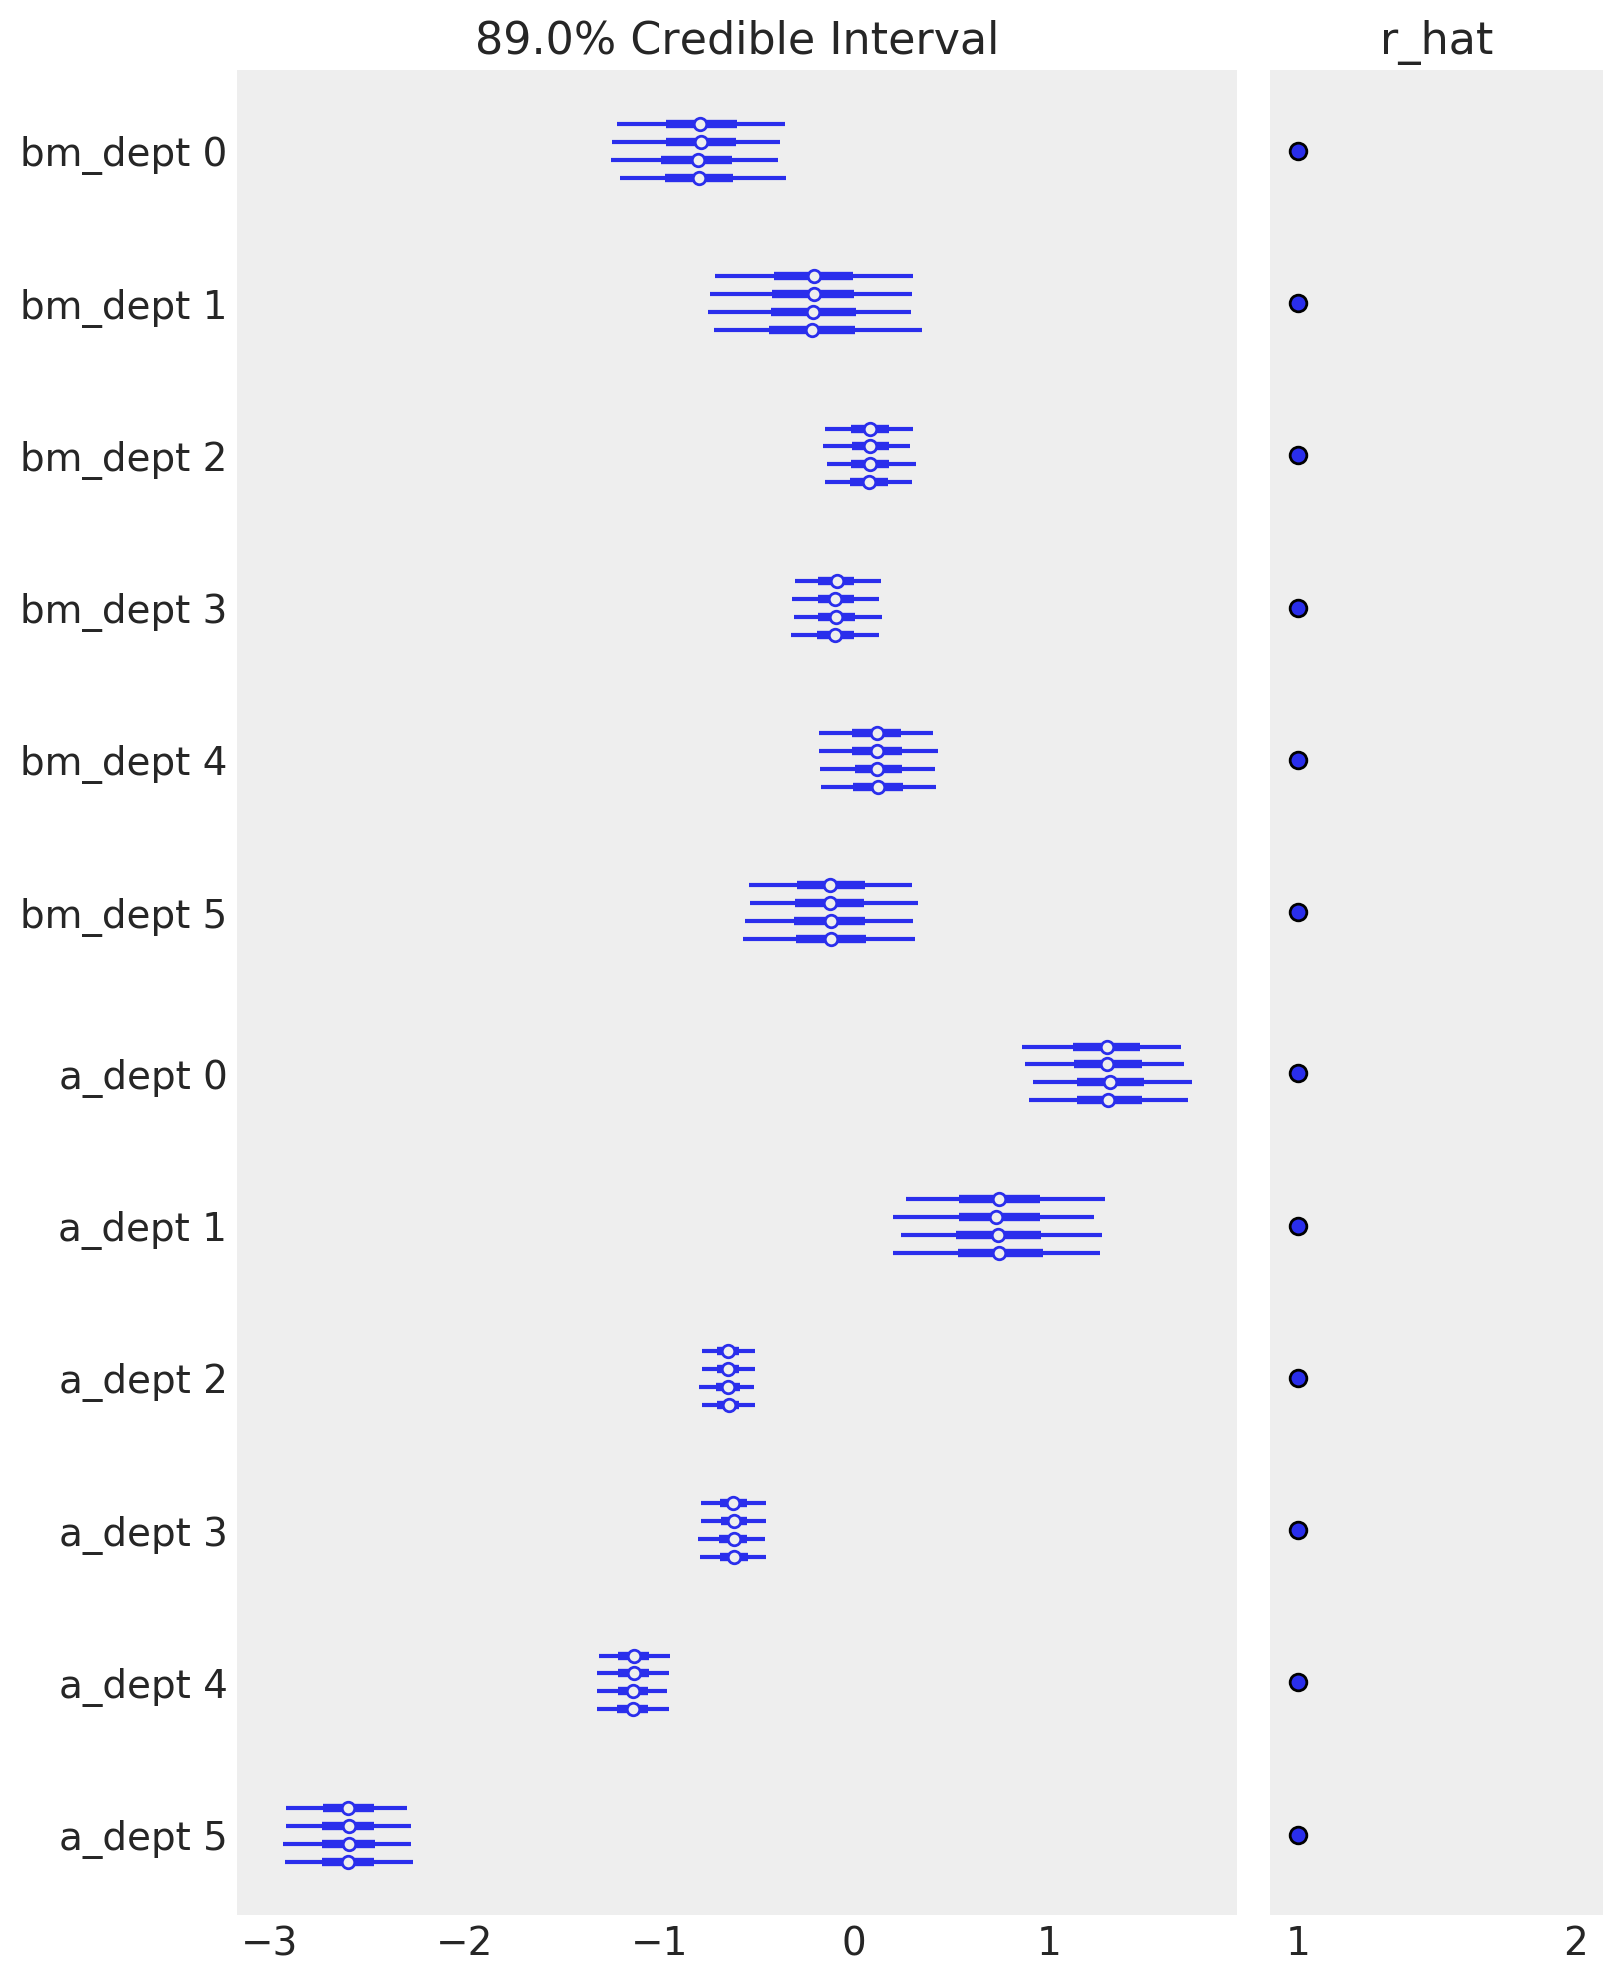

In [29]:
az.plot_forest(trace_13_3, var_names=['bm_dept', 'a_dept'], credible_interval=.89, r_hat=True);

### results of using `pm.LKJCorr` instead of `pm.LKJCholeskyCov`

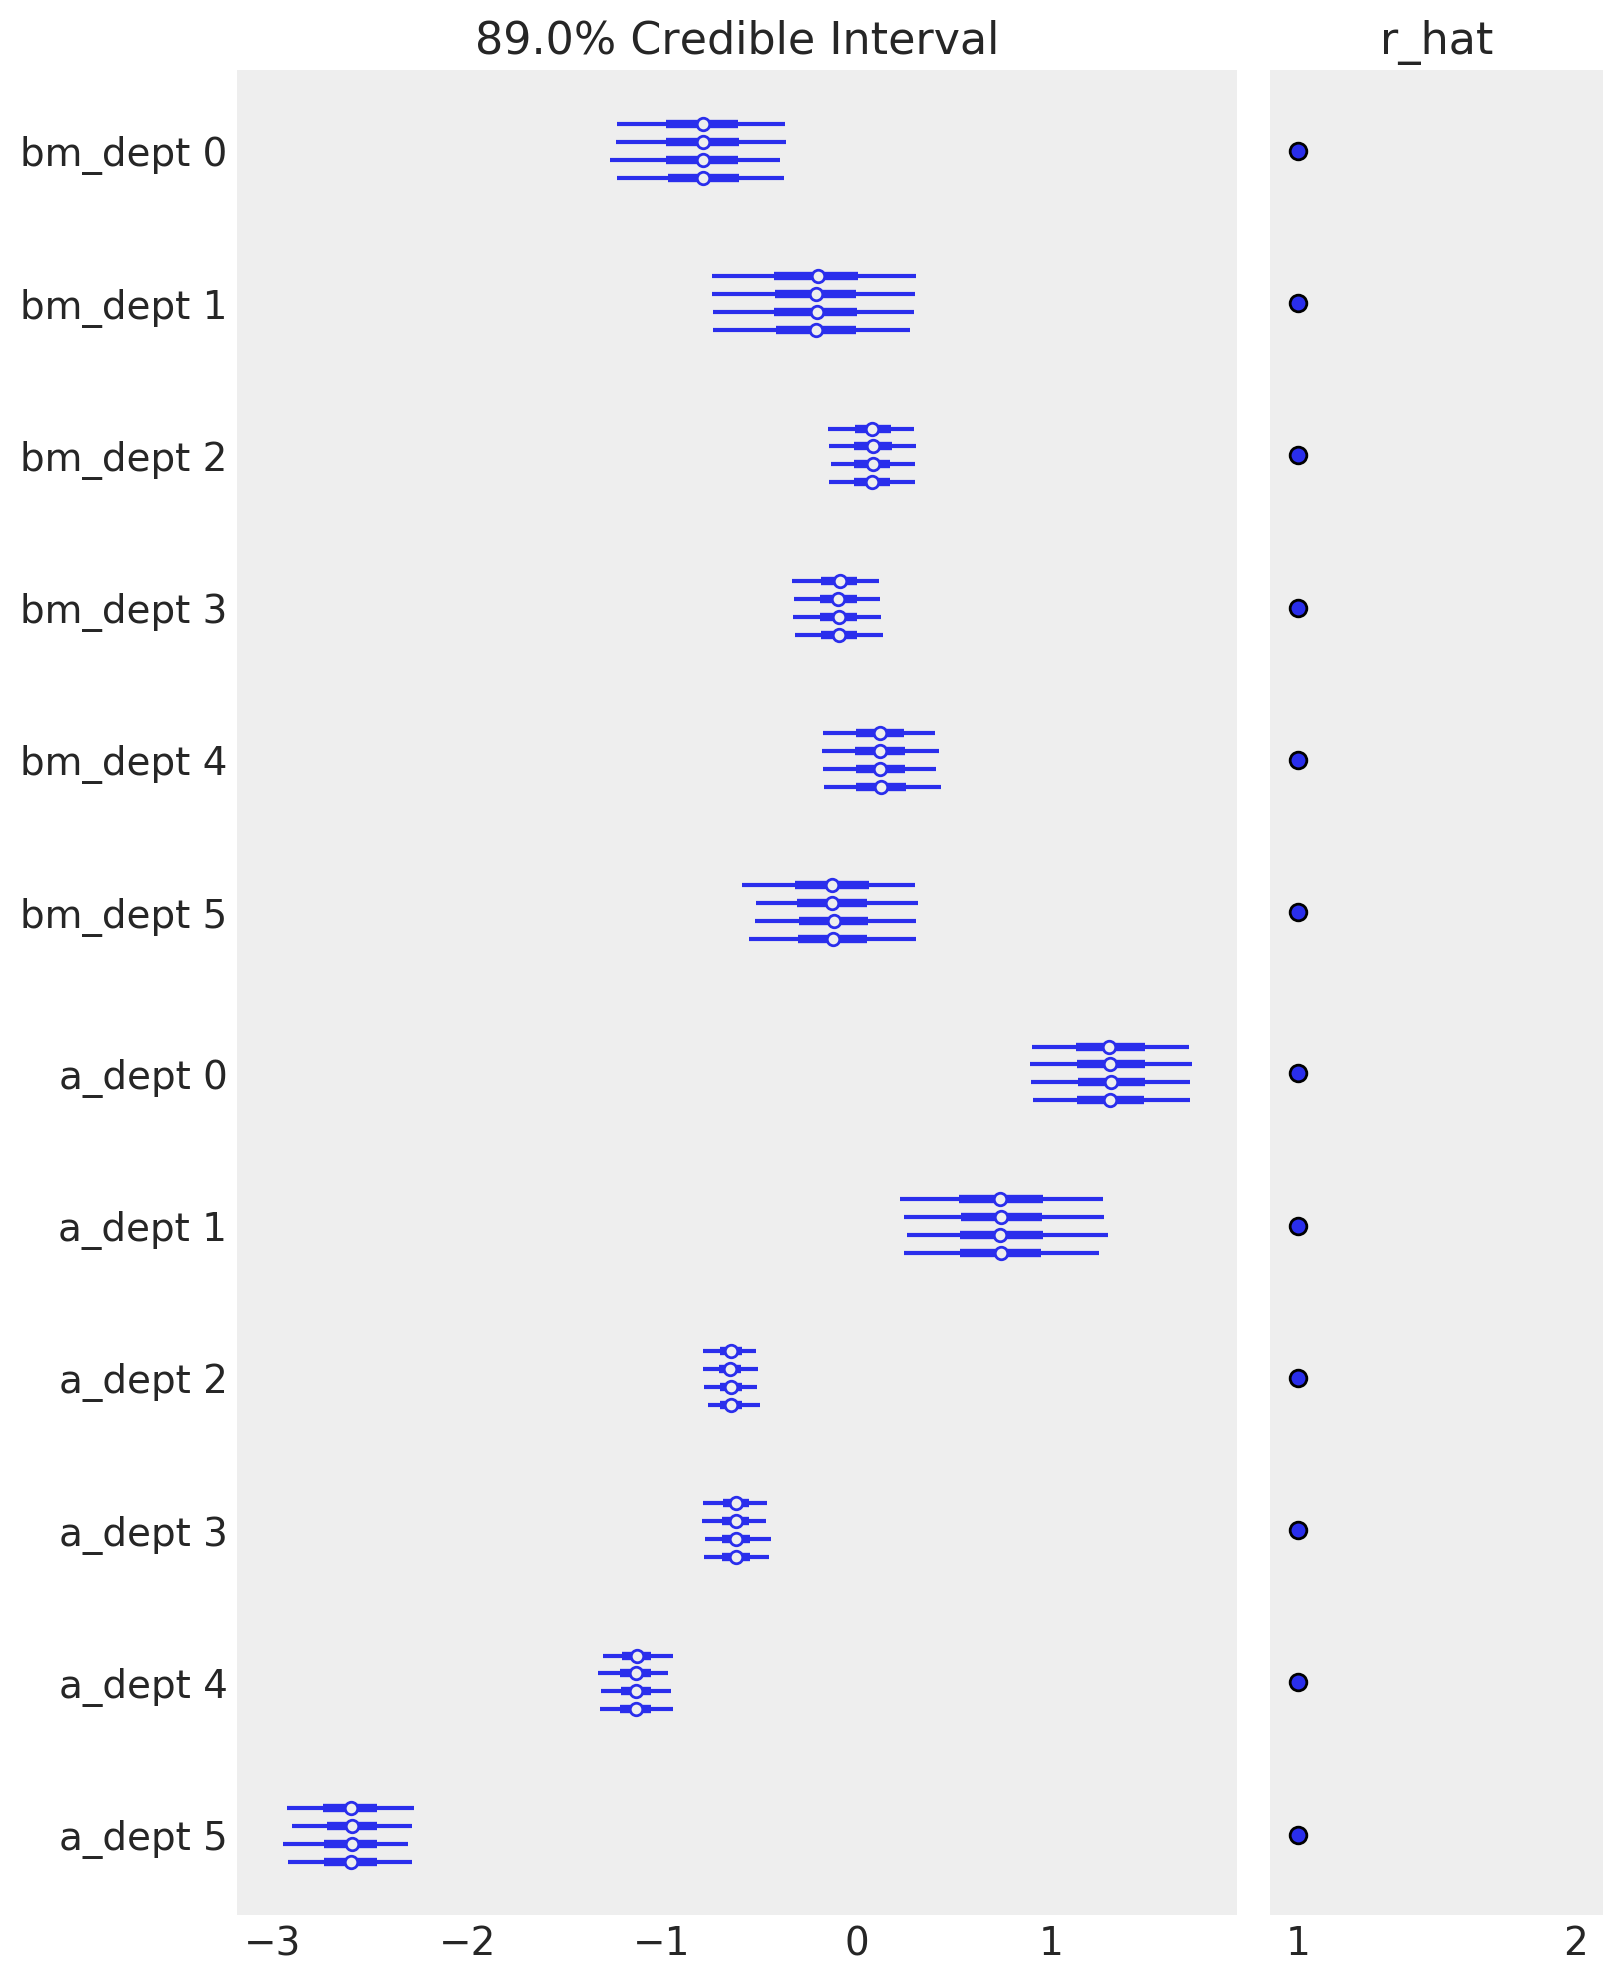

In [30]:
az.plot_forest(trace_13_3_alt, var_names=['bm_dept', 'a_dept'], credible_interval=.89, r_hat=True);

#### Code 13.21

In [31]:
with pm.Model() as m_13_4:
    a = pm.Normal('a', 0, 10)
    sigma_dept = pm.HalfCauchy('sigma_dept', 2)
    a_dept = pm.Normal('a_dept', a, sigma_dept, shape=Ndept)
    p = pm.math.invlogit(a_dept[Dept_id])
    admit = pm.Binomial('admit', p=p, n=d_ad.applications, observed=d_ad.admit)
    
    trace_13_4 = pm.sample(4500, tune=500)
    
comp_df = az.compare({'m13_2':trace_13_2,
                      'm13_3':trace_13_3,
                      'm13_4':trace_13_4})

comp_df

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a_dept, sigma_dept, a]
Sampling 4 chains: 100%|██████████| 20000/20000 [00:06<00:00, 3217.03draws/s]
/home/damianos/miniconda3/envs/statRethinkPymc3/lib/python3.7/site-packages/arviz/stats/stats.py:1078: UserWarning: For one or more samples the posterior variance of the log predictive
        densities exceeds 0.4. This could be indication of WAIC starting to fail see
        http://arxiv.org/abs/1507.04544 for details
        
  """
/home/damianos/miniconda3/envs/statRethinkPymc3/lib/python3.7/site-packages/arviz/stats/stats.py:1078: UserWarning: For one or more samples the posterior variance of the log predictive
        densities exceeds 0.4. This could be indication of WAIC starting to fail see
        http://arxiv.org/abs/1507.04544 for details
        
  """


waic   p_waic   d_waic     weight       se      dse warning  \
m13_3  90.9665  6.74706        0   0.860626  16.5969        0    True   
m13_4   105.18  6.53383  14.2138   0.124125  15.1201   14.769    True   
m13_2  108.572  9.42632  17.6058  0.0152489  4.39235  13.0236    True   

      waic_scale  
m13_3   deviance  
m13_4   deviance  
m13_2   deviance

#### Code 13.22

In [32]:
d = pd.read_csv('Data/chimpanzees.csv', sep=";")
# we change "actor" and "block" to zero-index
actor = (d['actor'] - 1).values
block = (d['block'] - 1).values
Nactor = len(np.unique(actor))
Nblock = len(np.unique(block))

with pm.Model() as model_13_6:
    sd_dist = pm.HalfCauchy.dist(beta=2)
    pchol1 = pm.LKJCholeskyCov('pchol_actor', eta=4, n=3, sd_dist=sd_dist)
    pchol2 = pm.LKJCholeskyCov('pchol_block', eta=4, n=3, sd_dist=sd_dist)
    chol1 = pm.expand_packed_triangular(3, pchol1, lower=True)
    chol2 = pm.expand_packed_triangular(3, pchol2, lower=True)
    
    Intercept = pm.Normal('intercept', 0., 1., shape=3)
    
    beta_actor = pm.MvNormal('beta_actor', mu=0., chol=chol1, shape=(Nactor, 3))
    beta_block = pm.MvNormal('beta_block', mu=0., chol=chol2, shape=(Nblock, 3))

    A = Intercept[0] + beta_actor[actor, 0] + beta_block[block, 0]
    BP = Intercept[1] + beta_actor[actor, 1] + beta_block[block, 1]
    BPC = Intercept[2] + beta_actor[actor, 2] + beta_block[block, 2]
    
    p = pm.math.invlogit(A + (BP + BPC*d['condition'])*d['prosoc_left'])
    pulled_left = pm.Binomial('pulled_left', 1, p, observed=d['pulled_left'])

    trace_13_6 = pm.sample(5000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_block, beta_actor, intercept, pchol_block, pchol_actor]
Sampling 4 chains: 100%|██████████| 24000/24000 [11:50<00:00,  7.03draws/s] 
There were 502 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6462233903887534, but should be close to 0.8. Try to increase the number of tuning steps.
There were 473 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6922259599741368, but should be close to 0.8. Try to increase the number of tuning steps.
There were 231 divergences after tuning. Increase `target_accept` or reparameterize.
There were 1179 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6898361182353342, but should 

#### Code 13.23

In [33]:
with pm.Model() as model_13_6NC:
    sd_dist = pm.HalfCauchy.dist(beta=2)
    pchol1 = pm.LKJCholeskyCov('pchol_actor', eta=4, n=3, sd_dist=sd_dist)
    pchol2 = pm.LKJCholeskyCov('pchol_block', eta=4, n=3, sd_dist=sd_dist)
    chol1 = pm.expand_packed_triangular(3, pchol1, lower=True)
    chol2 = pm.expand_packed_triangular(3, pchol2, lower=True)
    
    Intercept = pm.Normal('intercept', 0., 1., shape=3)
    
    b1 = pm.Normal('b1', 0., 1., shape=(3, Nactor))
    b2 = pm.Normal('b2', 0., 1., shape=(3, Nblock))
    beta_actor = pm.math.dot(chol1, b1)
    beta_block = pm.math.dot(chol2, b2)

    A = Intercept[0] + beta_actor[0, actor] + beta_block[0, block]
    BP = Intercept[1] + beta_actor[1, actor] + beta_block[1, block]
    BPC = Intercept[2] + beta_actor[2, actor] + beta_block[2, block]
    
    p = pm.math.invlogit(A + (BP + BPC*d['condition'])*d['prosoc_left'])
    pulled_left = pm.Binomial('pulled_left', 1, p, observed=d['pulled_left'])

    trace_13_6NC = pm.sample(5000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b2, b1, intercept, pchol_block, pchol_actor]
Sampling 4 chains: 100%|██████████| 24000/24000 [04:46<00:00, 83.83draws/s] 
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6937728710053765, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


#### Code 13.24

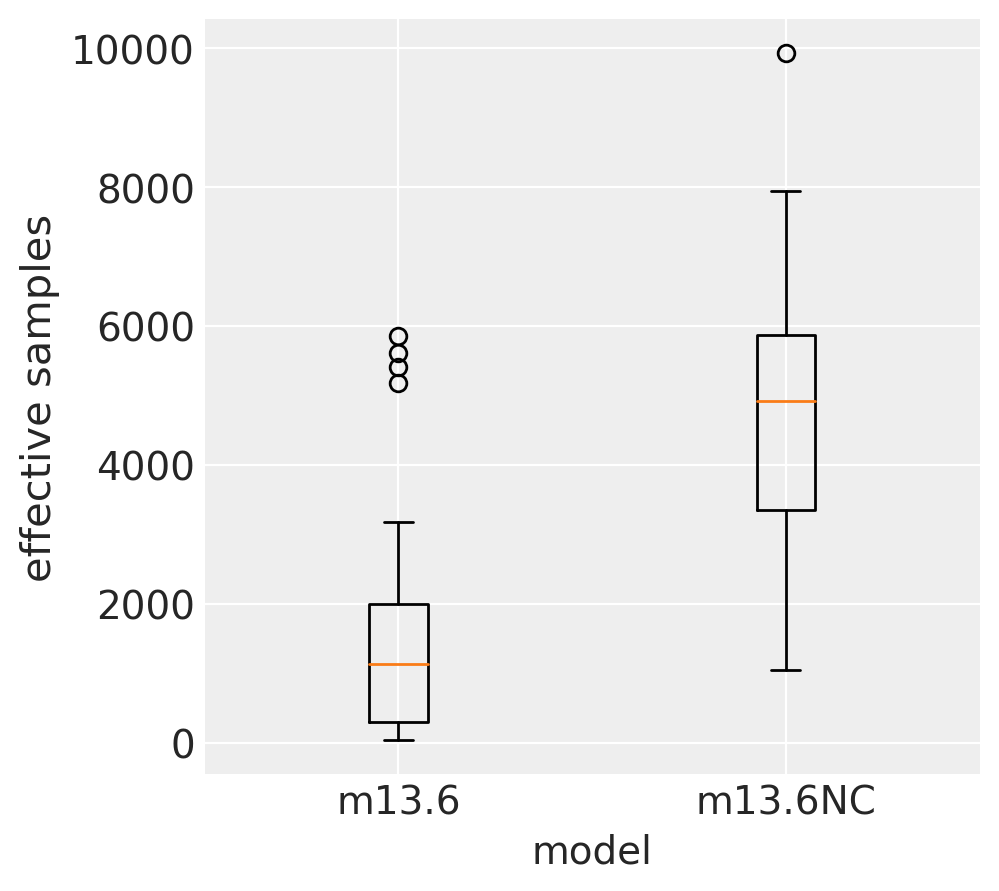

In [34]:
# extract n_eff values for each model
neff_c = az.summary(trace_13_6)['ess_bulk'].values
neff_nc = az.summary(trace_13_6NC)['ess_bulk'].values
# plot distributions
_, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.boxplot([neff_c, neff_nc], labels=['m13.6', 'm13.6NC']);
ax.set_xlabel('model', fontsize=14)
ax.set_ylabel('effective samples');

#### Code 13.25

In [35]:
# I didnt compute the sigma from the chol above, got to get a bit more creative here
def unpack_sigma(pack_chol):
    idxs = np.tril_indices(3)
    chol_ = np.zeros((3, 3, pack_chol.shape[0]))
    chol_[idxs] = pack_chol.T
    chol = np.transpose(chol_, (2, 0, 1))
    cholt= np.transpose(chol, (0, 2, 1))
    sigma = np.matmul(chol, cholt)
    return np.sqrt(np.diagonal(sigma, axis1=1, axis2=2))

sigmadict = dict(Sigma_actor=unpack_sigma(trace_13_6NC.get_values('pchol_actor', combine=True)),
                 Sigma_block=unpack_sigma(trace_13_6NC.get_values('pchol_block', combine=True)))
trace_13_6NC.add_values(sigmadict)
az.summary(trace_13_6NC, var_names=['Sigma_actor', 'Sigma_block'], round_to=2)

mean    sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  \
Sigma_actor[0]  2.36  0.96    0.97     4.00       0.04     0.03    598.98   
Sigma_actor[1]  0.45  0.36    0.01     1.06       0.01     0.00   2706.24   
Sigma_actor[2]  0.53  0.50    0.01     1.37       0.01     0.01   1923.36   
Sigma_block[0]  0.23  0.21    0.00     0.59       0.00     0.00   3099.76   
Sigma_block[1]  0.57  0.40    0.01     1.25       0.01     0.01   3162.20   
Sigma_block[2]  0.51  0.42    0.01     1.24       0.01     0.01   2967.87   

                 ess_sd  ess_bulk  ess_tail  r_hat  
Sigma_actor[0]   416.37   1729.59    620.63    1.0  
Sigma_actor[1]  2706.24   1081.54    377.70    1.0  
Sigma_actor[2]  1923.36   1512.07   1034.85    1.0  
Sigma_block[0]  3099.76   3084.86   3247.90    1.0  
Sigma_block[1]  3162.20   1268.77    478.87    1.0  
Sigma_block[2]  2967.87   2498.24   2629.40    1.0

#### Code 13.26
R and Rethinking related, skip for now

#### Code 13.27

In [36]:
with pm.Model() as m_12_5:
    bp = pm.Normal('bp', 0, 10)
    bpC = pm.Normal('bpC', 0, 10)
    
    a = pm.Normal('a', 0, 10)
    sigma_actor = pm.HalfCauchy('sigma_actor', 1.)
    a_actor = pm.Normal('a_actor', 0., sigma_actor, shape=Nactor)

    sigma_block = pm.HalfCauchy('sigma_block', 1.)
    a_block = pm.Normal('a_block', 0., sigma_block, shape=Nblock)
    
    p = pm.math.invlogit(a + a_actor[actor] + a_block[block]
                         + (bp + bpC * d['condition']) * d['prosoc_left'])
    pulled_left = pm.Binomial('pulled_left', 1, p, observed=d['pulled_left'])

    trace_12_5 = pm.sample(6000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a_block, sigma_block, a_actor, sigma_actor, a, bpC, bp]
Sampling 4 chains: 100%|██████████| 28000/28000 [01:10<00:00, 397.14draws/s]
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [37]:
comp_df = az.compare({'m13_6NC':trace_13_6NC,
                      'm12_5':trace_12_5})

comp_df

waic   p_waic   d_waic    weight       se      dse warning  \
m12_5    532.677  10.4502        0  0.665375  20.2659        0   False   
m13_6NC  534.974  18.4579  2.29654  0.334625  19.7539  4.05838   False   

        waic_scale  
m12_5     deviance  
m13_6NC   deviance

#### Code 13.28
Actually in model m_13_6NC I am already using the Cholesky decomposition of the covariance matrix. If we want to strictly follow the parameterization of m13.6NC and m13.6nc1 as in the book, we will model Rho using pm.LKJCorr and multiply it with pm.HalfCauchy.

#### Code 13.29

In [38]:
Dmat = pd.read_csv('Data/islandsDistMatrix.csv', sep=",", index_col=0)
Dmat.round(1)

Ml   Ti   SC   Ya   Fi   Tr   Ch   Mn   To   Ha
Malekula    0.0  0.5  0.6  4.4  1.2  2.0  3.2  2.8  1.9  5.7
Tikopia     0.5  0.0  0.3  4.2  1.2  2.0  2.9  2.7  2.0  5.3
Santa Cruz  0.6  0.3  0.0  3.9  1.6  1.7  2.6  2.4  2.3  5.4
Yap         4.4  4.2  3.9  0.0  5.4  2.5  1.6  1.6  6.1  7.2
Lau Fiji    1.2  1.2  1.6  5.4  0.0  3.2  4.0  3.9  0.8  4.9
Trobriand   2.0  2.0  1.7  2.5  3.2  0.0  1.8  0.8  3.9  6.7
Chuuk       3.2  2.9  2.6  1.6  4.0  1.8  0.0  1.2  4.8  5.8
Manus       2.8  2.7  2.4  1.6  3.9  0.8  1.2  0.0  4.6  6.7
Tonga       1.9  2.0  2.3  6.1  0.8  3.9  4.8  4.6  0.0  5.0
Hawaii      5.7  5.3  5.4  7.2  4.9  6.7  5.8  6.7  5.0  0.0

#### Code 13.30

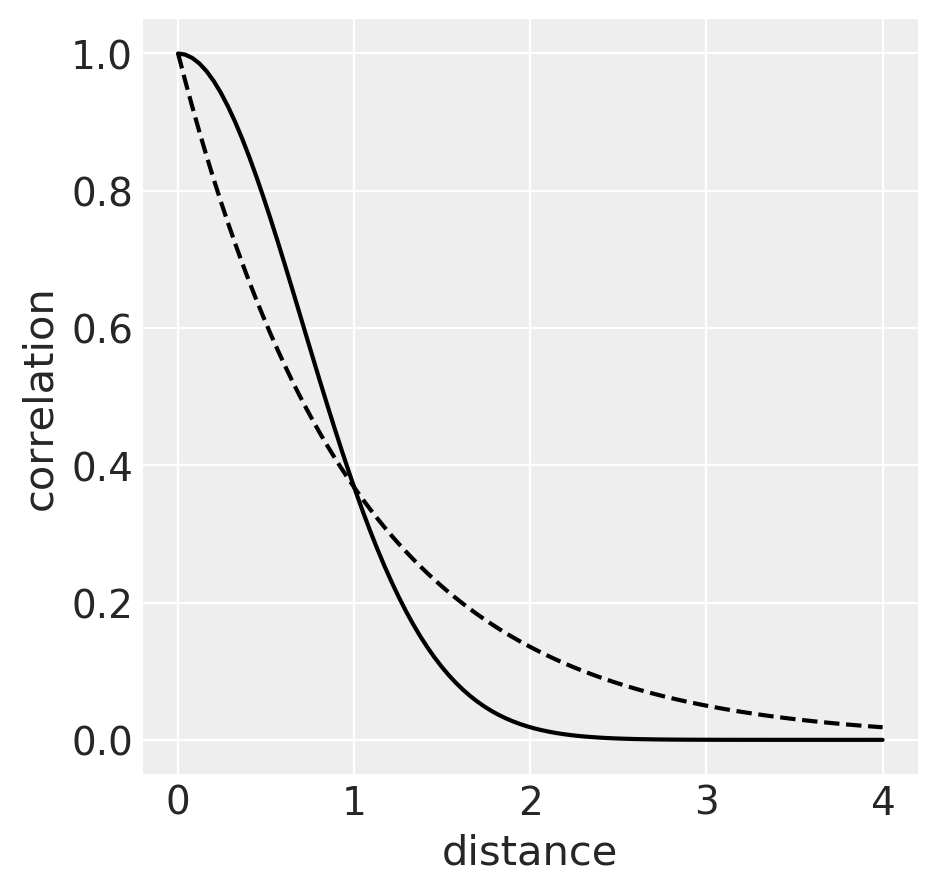

In [39]:
_, ax = plt.subplots(1, 1, figsize=(5, 5))
xrange = np.linspace(0, 4, 100)
ax.plot(xrange, np.exp(-1*xrange), 'k--')
ax.plot(xrange, np.exp(-1*xrange**2), 'k')
ax.set_xlabel('distance')
ax.set_ylabel('correlation');

#### Code 13.31

In [40]:
dk = pd.read_csv('Data/Kline2.csv', sep=",")
Nsociety = dk.shape[0]
dk.loc[:, 'society'] = np.arange(Nsociety)
Dmat_ = Dmat.values
Dmatsq = np.power(Dmat_, 2)

In [41]:
with pm.Model() as m_13_7:
    etasq = pm.HalfCauchy('etasq', 1)
    rhosq = pm.HalfCauchy('rhosq', 1)
    Kij = etasq*(tt.exp(-rhosq*Dmatsq)+np.diag([.01]*Nsociety))
    
    g = pm.MvNormal('g', mu=np.zeros(Nsociety), cov=Kij, shape=Nsociety)
    
    a = pm.Normal('a', 0, 10)
    bp = pm.Normal('bp', 0, 1)
    lam = pm.math.exp(a + g[dk.society.values] + bp*dk.logpop)
    obs = pm.Poisson('total_tools', lam, observed=dk.total_tools)
    trace_13_7 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bp, a, g, rhosq, etasq]
Sampling 4 chains: 100%|██████████| 8000/8000 [01:25<00:00, 22.05draws/s] 
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.666333422755497, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


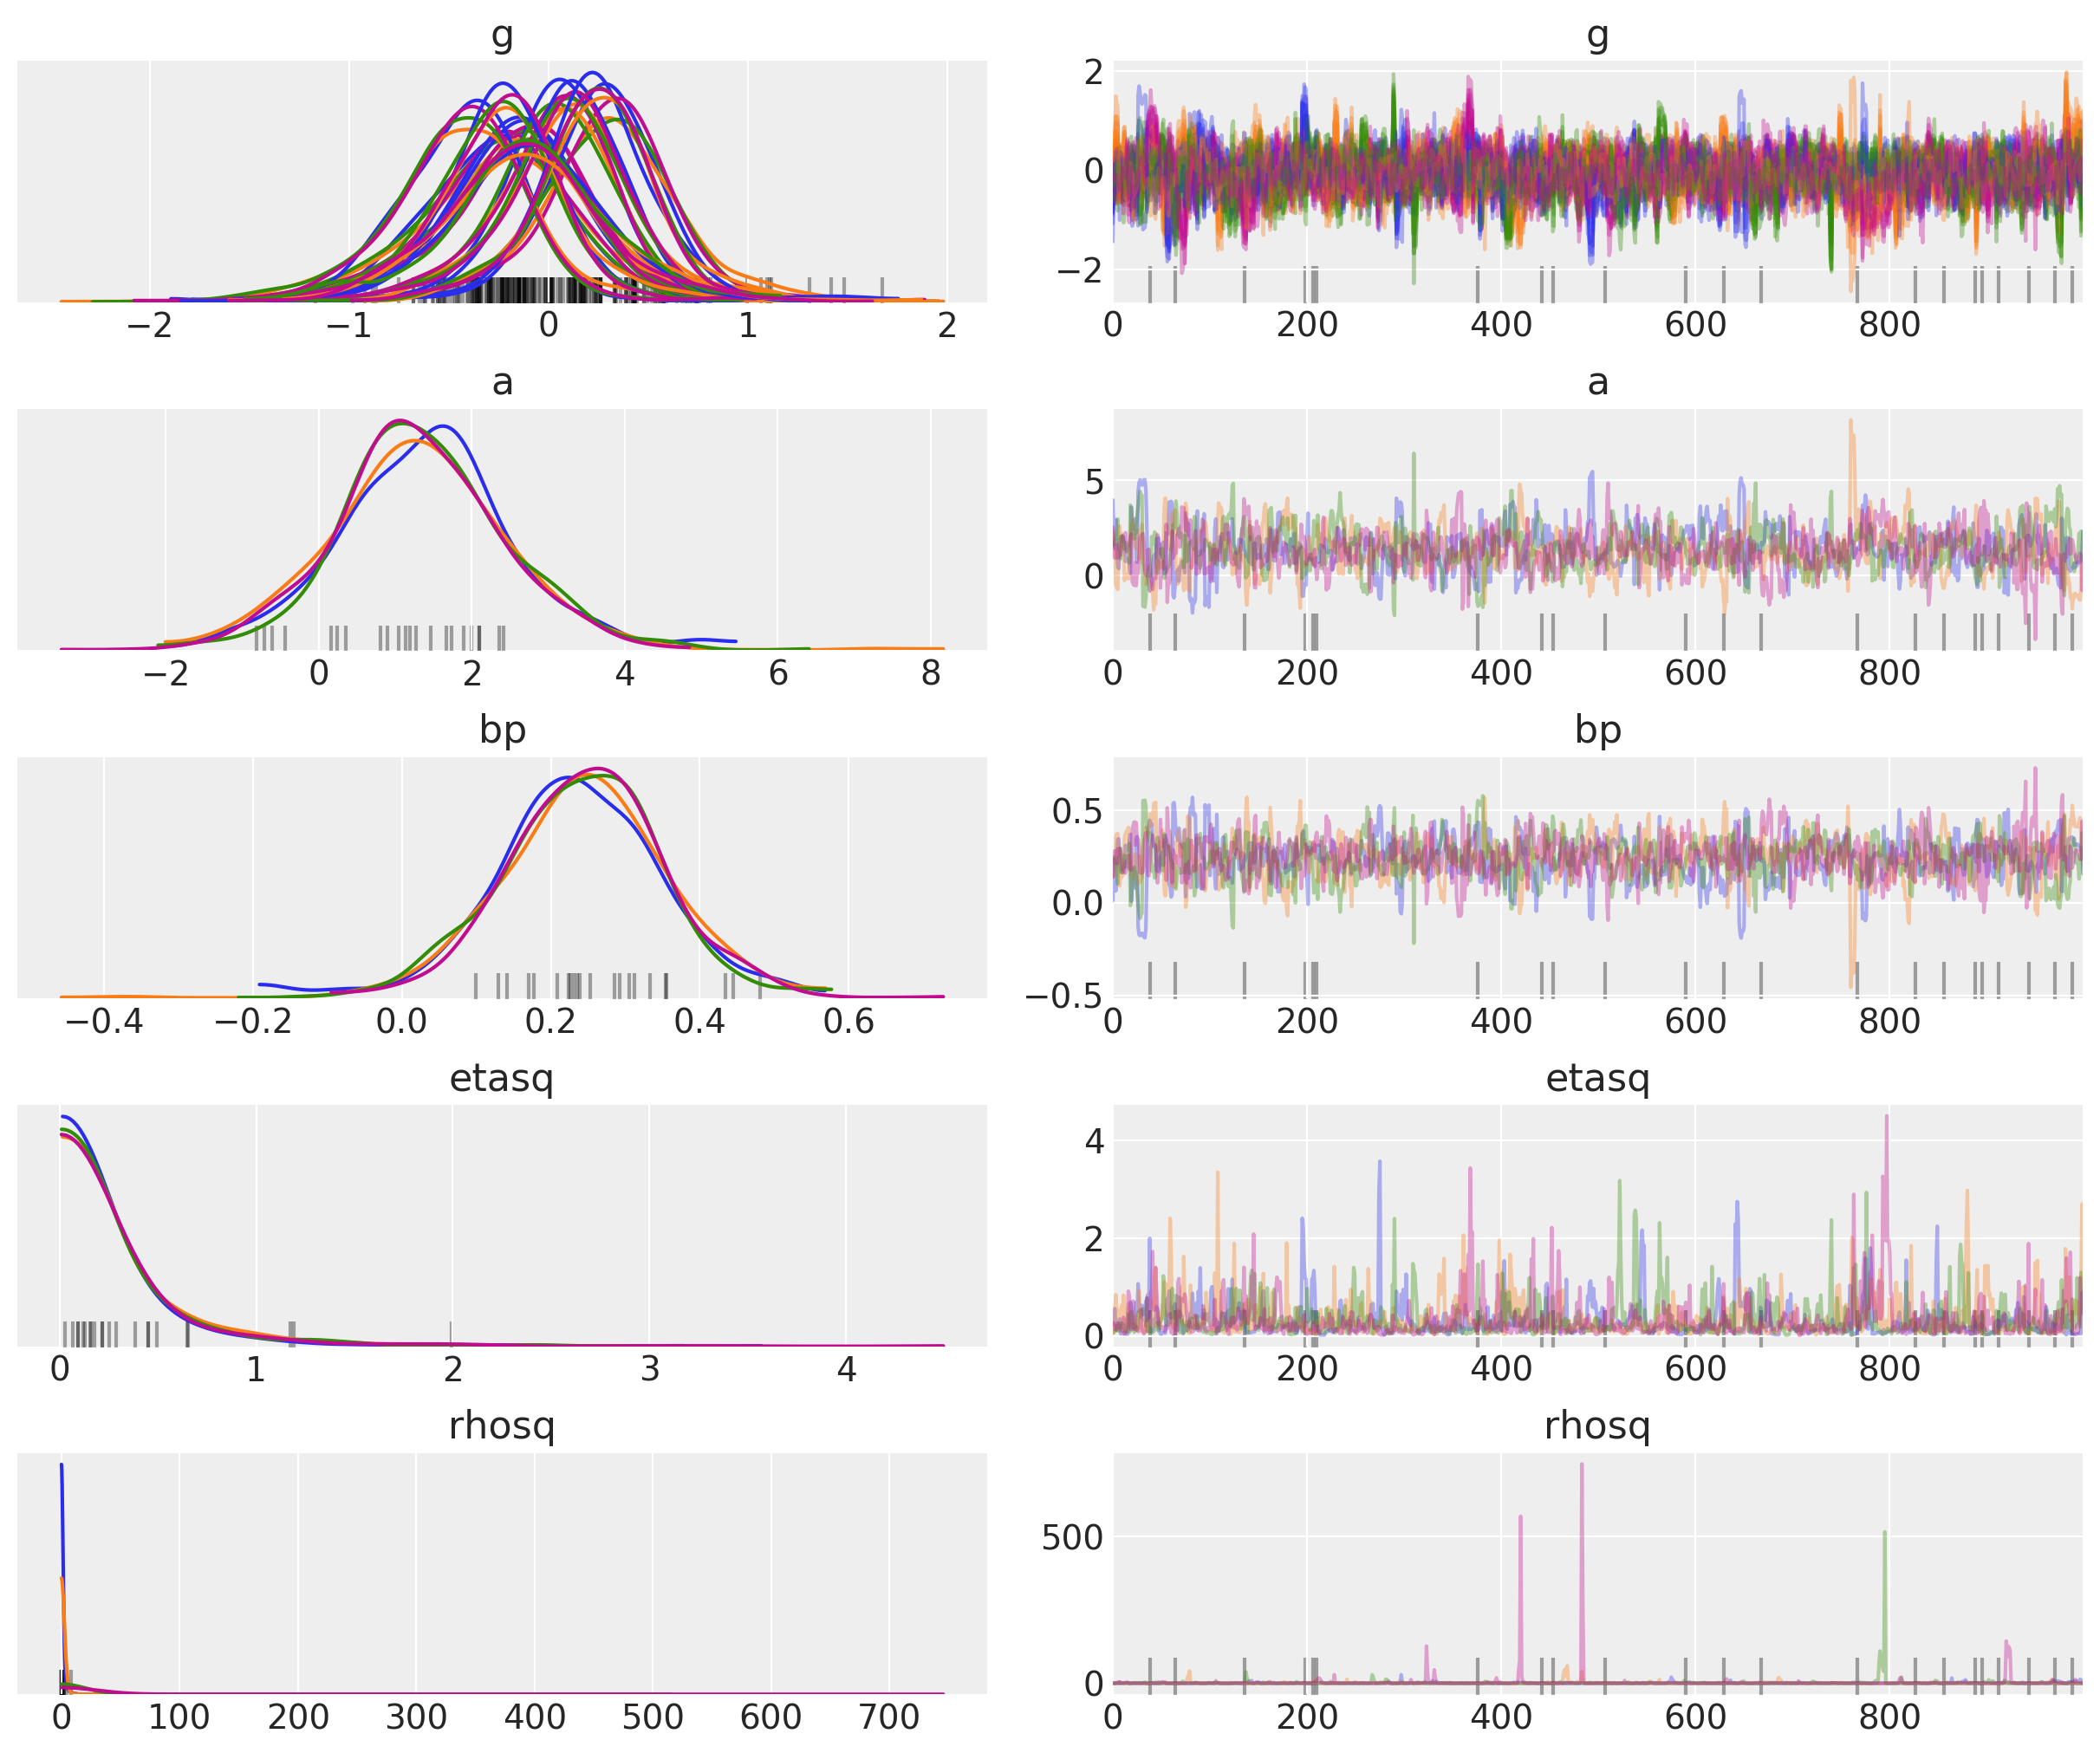

In [42]:
az.plot_trace(trace_13_7, var_names=['g', 'a', 'bp', 'etasq', 'rhosq'], compact=True);

A reparameterization of m13.7

In [43]:
with pm.Model() as m_13_7_:
    etasq = pm.HalfCauchy('etasq', 1)
    rhosq = pm.HalfCauchy('rhosq', 1)
    Kij = etasq * (tt.exp(-rhosq * Dmatsq) + np.diag([.01] * Nsociety))
    
    # g = pm.MvNormal('g', mu=np.zeros(Nsociety), cov=Kij, shape=Nsociety)
    gmu = pm.Normal('gmu', 0., 1., shape=Nsociety)
    g = pm.Deterministic('g', pm.math.dot(tt.slinalg.cholesky(Kij), gmu))
    
    a = pm.Normal('a', 0, 10)
    bp = pm.Normal('bp', 0, 1)
    lam = pm.math.exp(a + g[dk.society.values] + bp * dk.logpop)
    obs = pm.Poisson('total_tools', lam, observed=dk.total_tools)
    trace_13_7_ = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bp, a, gmu, rhosq, etasq]
Sampling 4 chains: 100%|██████████| 8000/8000 [01:17<00:00, 30.93draws/s] 
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


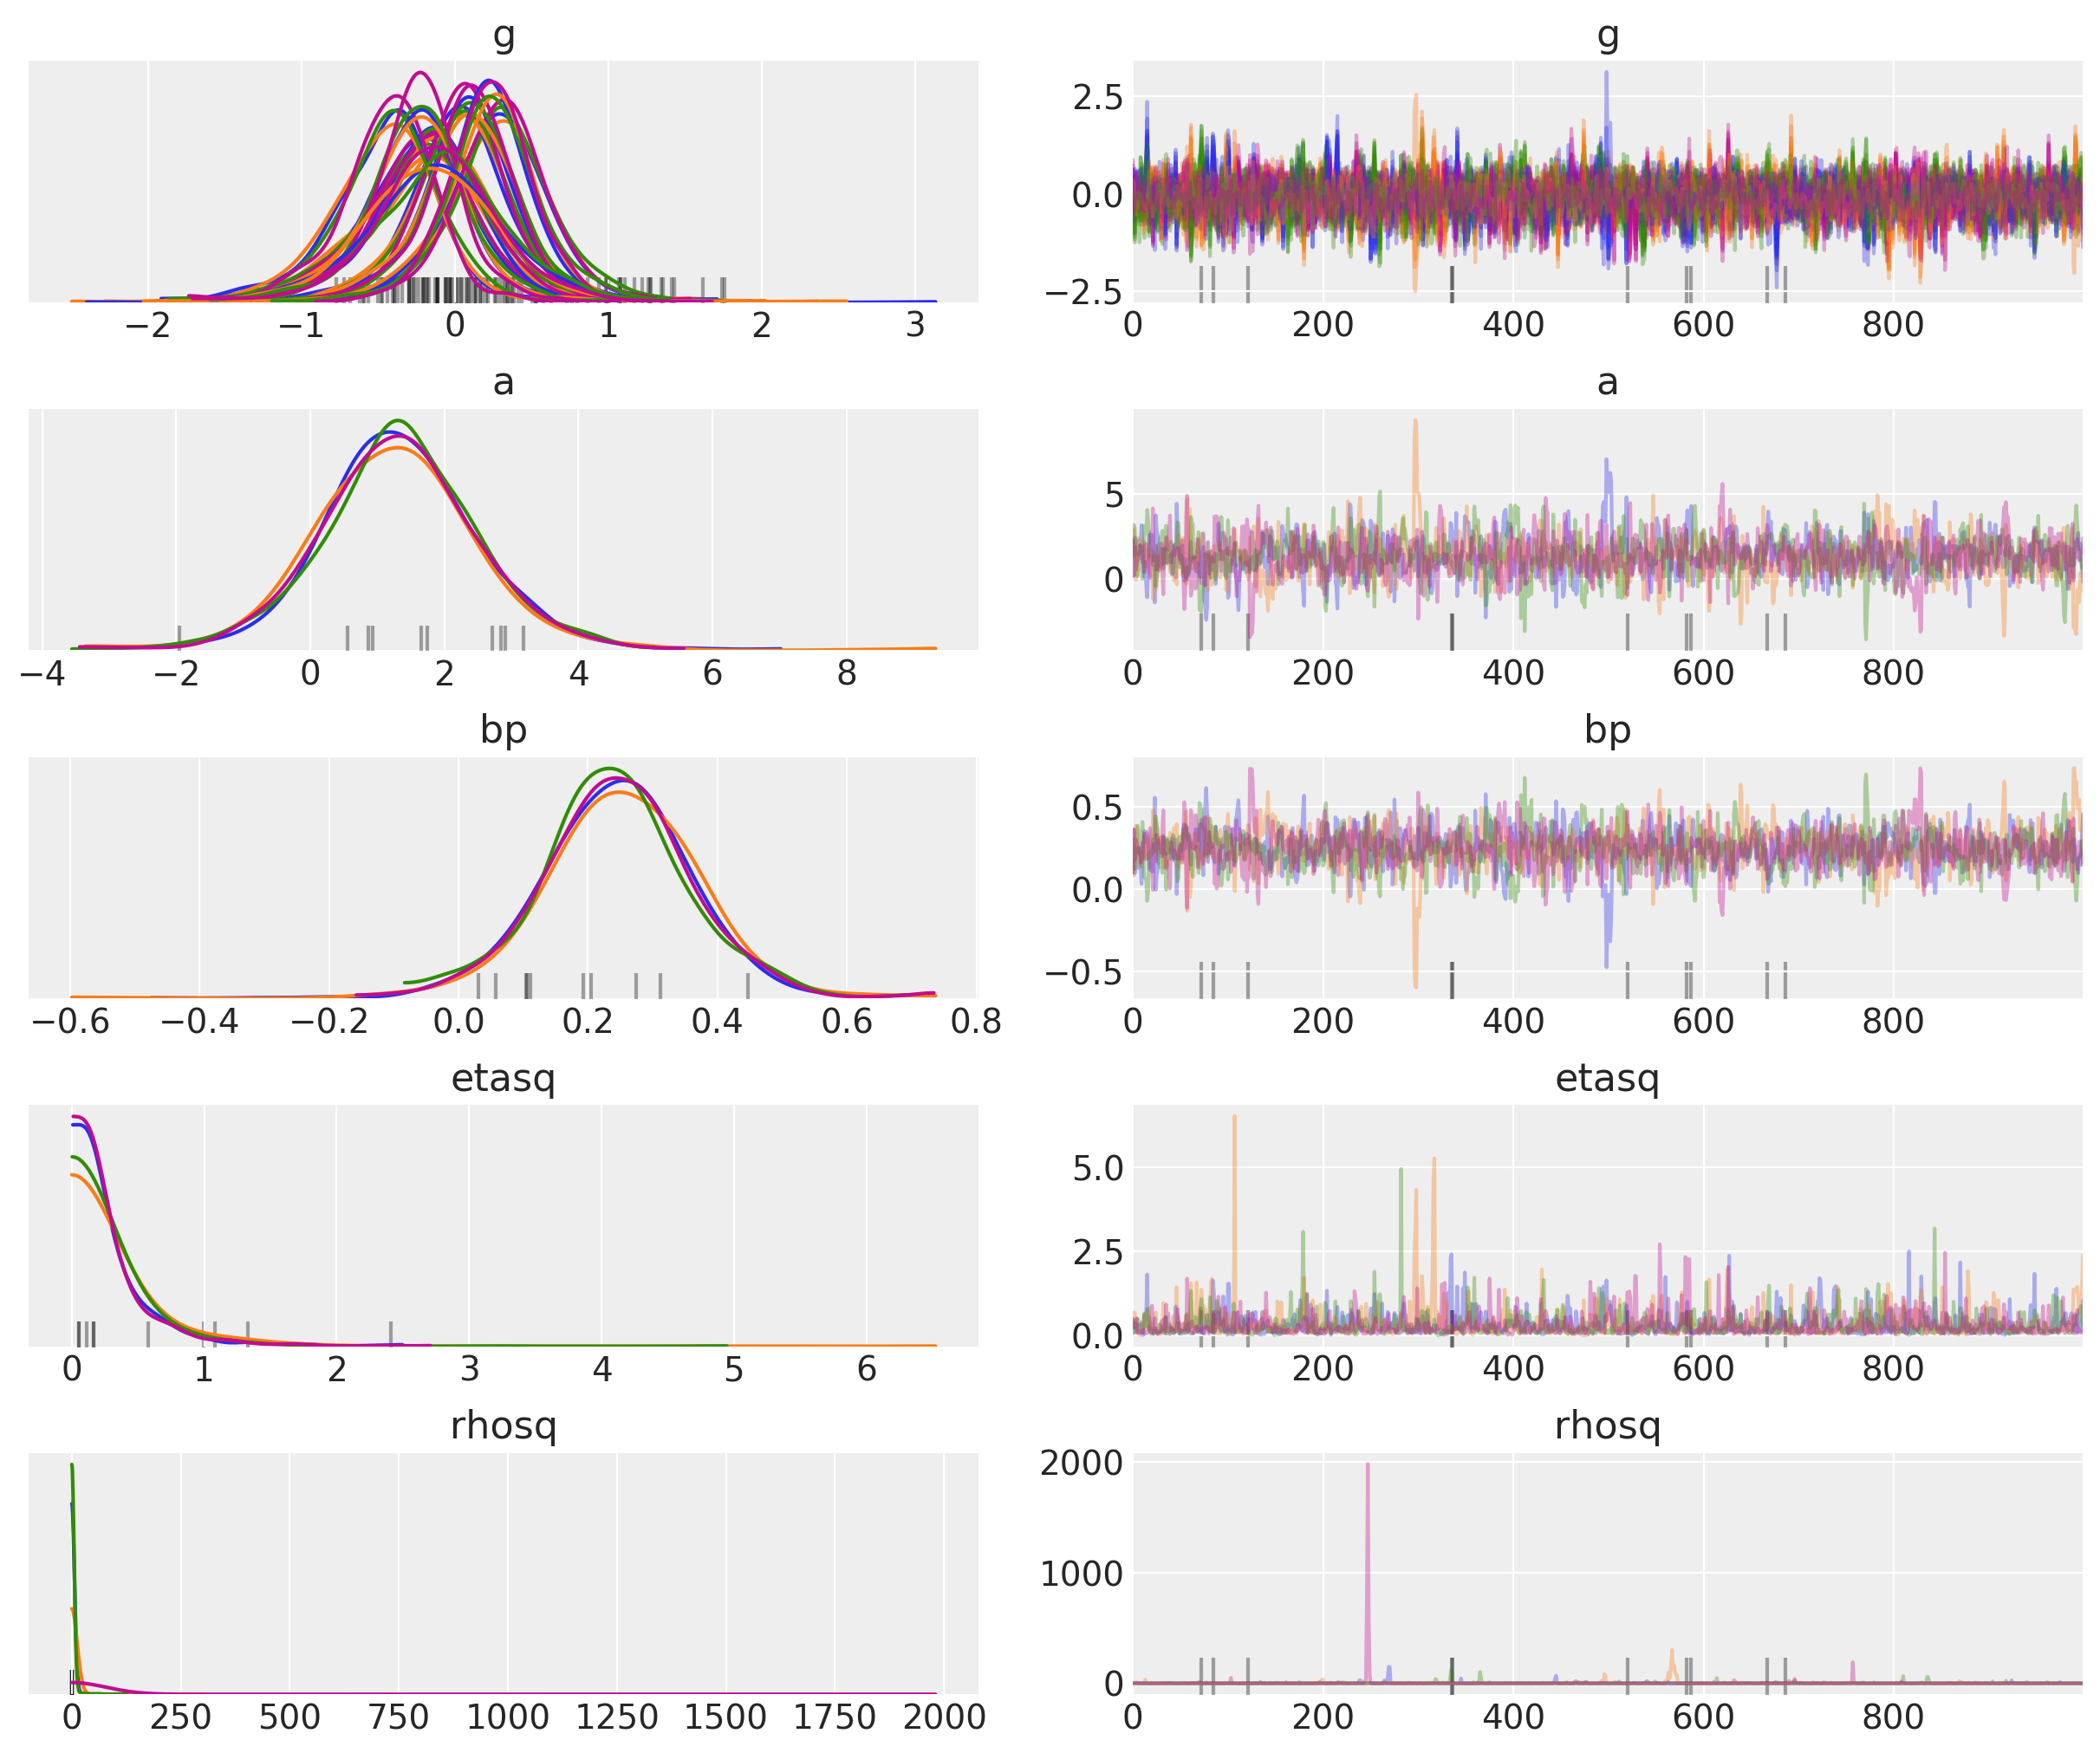

In [44]:
az.plot_trace(trace_13_7_, var_names=['g', 'a', 'bp', 'etasq', 'rhosq'], compact=True);

#### Code 13.32

In [45]:
# Summary of centered model
az.summary(trace_13_7, var_names=['g', 'a', 'bp', 'etasq', 'rhosq'], round_to=2)

mean     sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean   ess_sd  \
g[0]  -0.27   0.41   -1.06     0.51       0.02     0.01    550.81   550.81   
g[1]  -0.14   0.39   -0.89     0.62       0.02     0.01    507.12   507.12   
g[2]  -0.18   0.38   -1.01     0.47       0.02     0.01    522.66   522.66   
g[3]   0.29   0.34   -0.44     0.90       0.01     0.01    570.35   570.35   
g[4]   0.04   0.33   -0.71     0.60       0.01     0.01    547.38   547.38   
g[5]  -0.45   0.34   -1.14     0.16       0.01     0.01    580.88   580.88   
g[6]   0.10   0.33   -0.58     0.70       0.01     0.01    558.25   558.25   
g[7]  -0.26   0.33   -0.97     0.34       0.01     0.01    582.34   582.34   
g[8]   0.23   0.31   -0.40     0.82       0.01     0.01    608.62   608.62   
g[9]  -0.10   0.43   -0.93     0.73       0.01     0.01   1133.16   783.00   
a      1.35   1.12   -0.81     3.45       0.04     0.03    735.53   735.53   
bp     0.24   0.11    0.03     0.45       0.00     0.00    941.78   941.78   
etasq  0.32   0.37    0.01     0.92       0.01     0.01    724.63   724.63   
rhosq  1.91  18.45    0.01     3.37       0.42     0.30   1925.58  1925.58   

       ess_bulk  ess_tail  r_hat  
g[0]     560.80    776.49   1.00  
g[1]     514.69    723.15   1.00  
g[2]     545.76    655.43   1.00  
g[3]     593.41    704.83   1.01  
g[4]     578.28    672.16   1.01  
g[5]     625.31    666.39   1.00  
g[6]     606.78    595.51   1.00  
g[7]     625.12    707.06   1.00  
g[8]     655.54    777.10   1.00  
g[9]    1158.52   1013.88   1.00  
a        742.93   1005.24   1.00  
bp       955.94   1054.61   1.00  
etasq    764.01   1315.24   1.00  
rhosq    648.02    824.68   1.00

In [46]:
# Summary of non-centered model
az.summary(trace_13_7_, var_names=['g', 'a', 'bp', 'etasq', 'rhosq'], round_to=2)

mean     sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean   ess_sd  \
g[0]  -0.26   0.42   -1.13     0.52       0.01     0.01   1655.80  1621.93   
g[1]  -0.14   0.41   -0.98     0.60       0.01     0.01   1618.59  1618.59   
g[2]  -0.17   0.39   -0.97     0.55       0.01     0.01   1701.02  1701.02   
g[3]   0.30   0.35   -0.38     0.95       0.01     0.01   1902.65  1902.65   
g[4]   0.04   0.34   -0.61     0.71       0.01     0.01   2004.56  2004.56   
g[5]  -0.46   0.35   -1.15     0.17       0.01     0.01   2150.98  2074.94   
g[6]   0.10   0.33   -0.61     0.69       0.01     0.01   1987.98  1987.98   
g[7]  -0.26   0.34   -0.97     0.34       0.01     0.01   2275.19  1951.23   
g[8]   0.23   0.32   -0.37     0.85       0.01     0.00   2034.79  2034.79   
g[9]  -0.12   0.44   -0.95     0.76       0.01     0.01   1612.79  1504.51   
a      1.32   1.17   -0.92     3.47       0.03     0.02   1312.35  1203.43   
bp     0.24   0.12    0.03     0.47       0.00     0.00   1317.64  1317.64   
etasq  0.32   0.37    0.01     0.89       0.01     0.01   1688.41  1688.41   
rhosq  2.63  36.20    0.01     3.70       0.92     0.65   1532.44  1532.44   

       ess_bulk  ess_tail  r_hat  
g[0]    1686.92   2204.77    1.0  
g[1]    1624.15   1906.85    1.0  
g[2]    1720.85   2014.07    1.0  
g[3]    1882.34   2213.50    1.0  
g[4]    2036.13   2150.93    1.0  
g[5]    2155.12   2545.12    1.0  
g[6]    1975.21   2198.88    1.0  
g[7]    2291.28   2308.31    1.0  
g[8]    2063.98   2113.70    1.0  
g[9]    1670.75   1807.86    1.0  
a       1362.70   1466.53    1.0  
bp      1384.89   1427.55    1.0  
etasq   1364.65   2233.55    1.0  
rhosq   1179.17   1467.82    1.0

#### Code 13.33

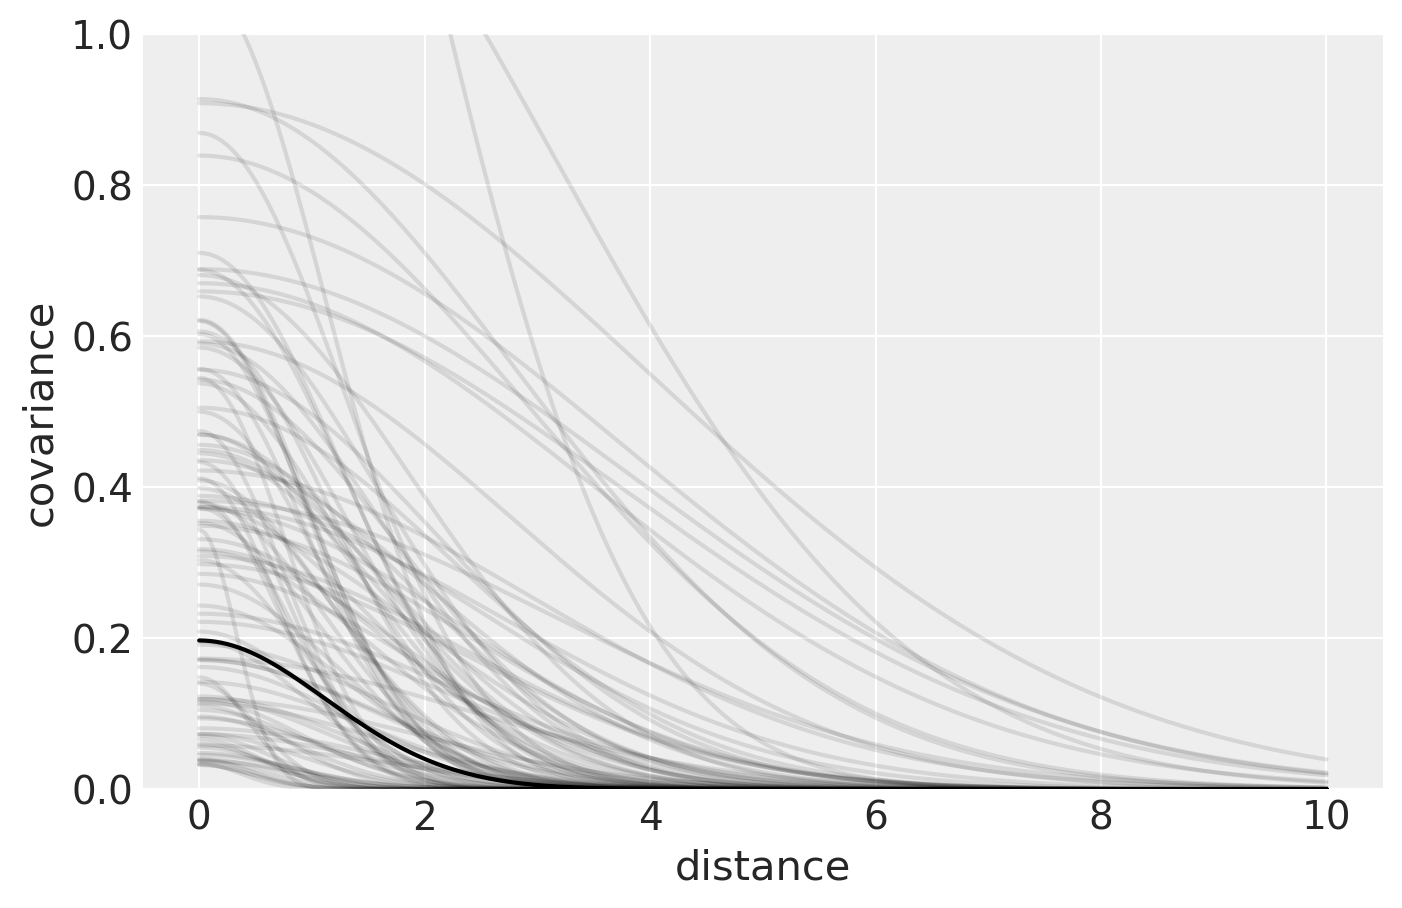

In [47]:
post = pm.trace_to_dataframe(trace_13_7, varnames=['g', 'a', 'bp', 'etasq', 'rhosq'])
post_etasq = post['etasq'].values
post_rhosq = post['rhosq'].values

_, ax = plt.subplots(1, 1, figsize=(8, 5))
xrange = np.linspace(0, 10, 200)

ax.plot(xrange, np.median(post_etasq) * np.exp(-np.median(post_rhosq) * xrange**2), 'k')
ax.plot(xrange, (post_etasq[:100][:, None] * np.exp(-post_rhosq[:100][:, None] * xrange**2)).T,
        'k', alpha=.1)

ax.set_ylim(0, 1)
ax.set_xlabel('distance')
ax.set_ylabel('covariance');

#### Code 13.34

In [48]:
# compute posterior median covariance among societies
Kij_post = np.median(post_etasq) * (np.exp(-np.median(post_rhosq) * Dmatsq) + np.diag([.01] * Nsociety))

#### Code 13.35

In [49]:
# convert to correlation matrix
sigma_post = np.sqrt(np.diag(Kij_post))
Rho = np.diag(sigma_post**-1).dot(Kij_post.dot(np.diag(sigma_post**-1)))
# add row/col names for convenience
Rho = pd.DataFrame(Rho, index=["Ml","Ti","SC","Ya","Fi","Tr","Ch","Mn","To","Ha"],
                  columns=["Ml","Ti","SC","Ya","Fi","Tr","Ch","Mn","To","Ha"])

Rho.round(2)

Ml    Ti    SC    Ya    Fi    Tr    Ch    Mn    To   Ha
Ml  1.00  0.91  0.84  0.00  0.54  0.19  0.02  0.04  0.25  0.0
Ti  0.91  1.00  0.95  0.00  0.54  0.20  0.04  0.06  0.21  0.0
SC  0.84  0.95  1.00  0.00  0.38  0.31  0.07  0.11  0.13  0.0
Ya  0.00  0.00  0.00  1.00  0.00  0.09  0.38  0.35  0.00  0.0
Fi  0.54  0.54  0.38  0.00  1.00  0.02  0.00  0.00  0.79  0.0
Tr  0.19  0.20  0.31  0.09  0.02  1.00  0.27  0.74  0.00  0.0
Ch  0.02  0.04  0.07  0.38  0.00  0.27  1.00  0.55  0.00  0.0
Mn  0.04  0.06  0.11  0.35  0.00  0.74  0.55  1.00  0.00  0.0
To  0.25  0.21  0.13  0.00  0.79  0.00  0.00  0.00  1.00  0.0
Ha  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  1.0

#### Code 13.36

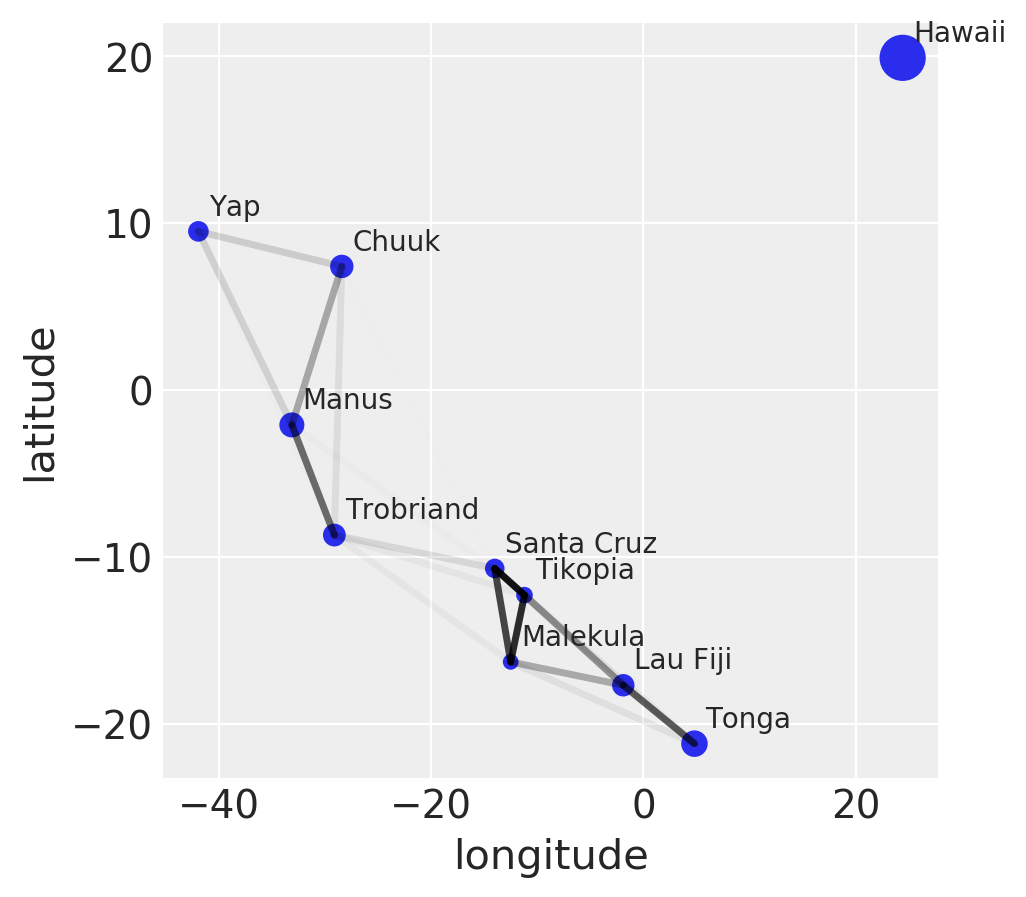

In [50]:
# scale point size to logpop
logpop = np.copy(dk['logpop'].values)
logpop /= logpop.max()
psize = np.exp(logpop*5.5)

_, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.scatter(dk['lon2'], dk['lat'], psize);
labels = dk['culture'].values
for i, itext in enumerate(labels):
    ax.text(dk['lon2'][i]+1, dk['lat'][i]+1, itext)
# overlay lines shaded by Rho
for i in range(10):
    for j in np.arange(i+1, 10):
        ax.plot([dk['lon2'][i], dk['lon2'][j]],
                [dk['lat'][i], dk['lat'][j]], 'k-', 
                alpha=Rho.iloc[i, j]**2, lw=2.5)
ax.set_xlabel('longitude')
ax.set_ylabel('latitude');

#### Code 13.37

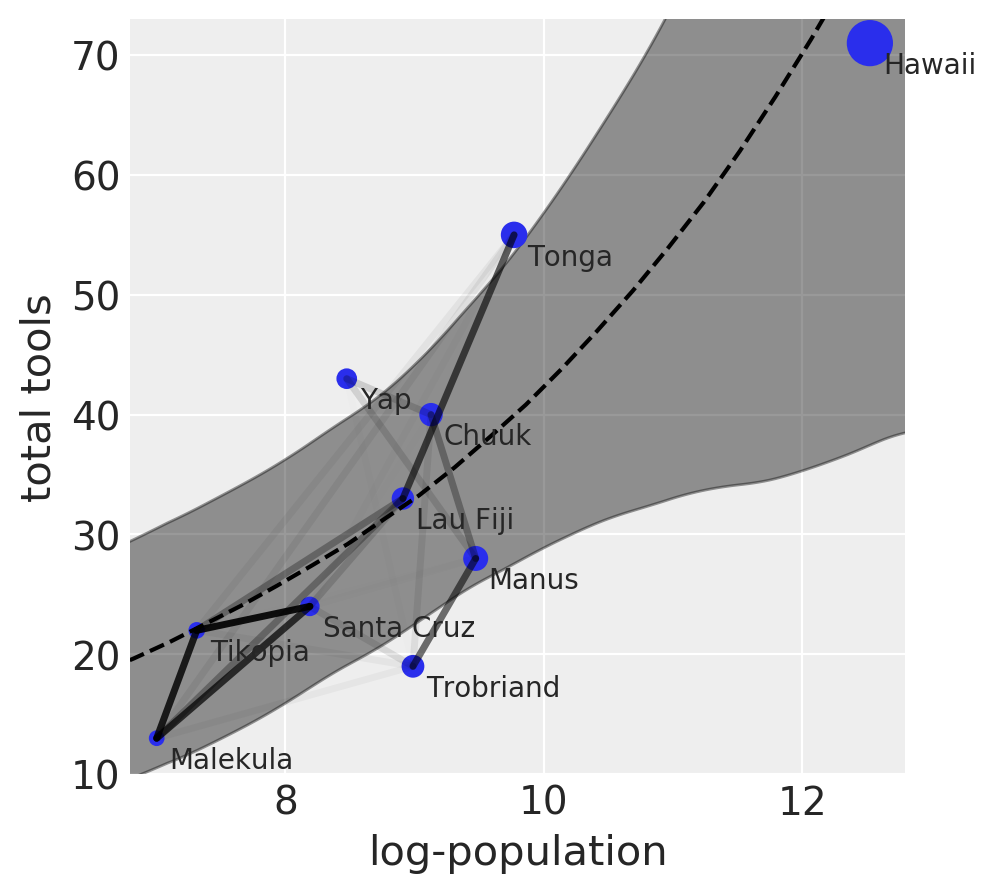

In [51]:
# compute posterior median relationship, ignoring distance
Nsamp, Nbin = 1000, 30
log_pop_seq = np.linspace(6, 14, Nbin)
a_post = trace_13_7.get_values(varname='a', combine=True)[:, None]
bp_post = trace_13_7.get_values(varname='bp', combine=True)[:, None]
lambda_post = np.exp(a_post + bp_post*log_pop_seq)

_, axes = plt.subplots(1, 1, figsize=(5, 5))
cred_interval = .8

# display posterior predictions
axes.plot(log_pop_seq, np.median(lambda_post, axis=0), '--', color='k')


az.plot_hpd(log_pop_seq, lambda_post, credible_interval=cred_interval,
            color='k', fill_kwargs={'alpha':cred_interval*.5})

# plot raw data and labels
axes.scatter(dk['logpop'], dk['total_tools'], psize)
labels = dk['culture'].values
for i, itext in enumerate(labels):
    axes.text(dk['logpop'][i]+.1, dk['total_tools'][i]-2.5, itext)
    
# overlay correlations
for i in range(10):
    for j in np.arange(i+1, 10):
        axes.plot([dk['logpop'][i], dk['logpop'][j]],
                [dk['total_tools'][i], dk['total_tools'][j]], 'k-', 
                alpha=Rho.iloc[i, j]**2, lw=2.5)
        
axes.set_xlabel('log-population')
axes.set_ylabel('total tools')
axes.set_xlim(6.8, 12.8)
axes.set_ylim(10, 73);

In [52]:
import sys, IPython, scipy, matplotlib
print("""This notebook was created using:\nPython {}\nIPython {}\nPyMC3 {}\nArviZ {}\nNumPy {}\nSciPy {}\nMatplotlib {}\n""".format(sys.version[:5], IPython.__version__, pm.__version__, az.__version__, np.__version__, scipy.__version__, matplotlib.__version__))

This notebook was created using:
Python 3.7.2
IPython 7.6.1
PyMC3 3.6
ArviZ 0.4.1
NumPy 1.16.0
SciPy 1.2.0
Matplotlib 3.0.2

